In [1]:
import torch
import torch.nn as nn
import yaml
import sys
import torch_fidelity

In [2]:
with open('./model_config.yml', 'r') as file:
    config = yaml.safe_load(file)
    decoder_config = config["Decoder"]
    prior_config = config["Prior"]
    clip_config = config["CLIP"]

In [3]:
sys.path.insert(0, 'clip')
from clip.model import CLIP

sys.path.insert(0, 'dalle2')
from prior import Prior
from decoder import UNet, Decoder
from diffusion import Diffusion
from dalle2_model import DALLE2

In [4]:
decoder_path = "./models/decoder3_cosine_ori2.pth"
prior_path = "./models/prior3_cosine.pth"
clip_path = "./models/clip3.pth"


decoder_state = torch.load(decoder_path)
prior_state = torch.load(prior_path)
clip_state = torch.load(clip_path)

decoder_config = decoder_state["config"]["Decoder"]
prior_config = prior_state["config"]["Prior"]
clip_config = clip_state["config"]["CLIP"]

In [5]:
# Define hyperparameters
T = decoder_config["diffusion_timesteps"]
BATCH_SIZE = decoder_config["batch_size"]
IMG_SIZE = config["img_size"]
EPOCHS = decoder_config["epochs"]
LR = decoder_config["lr"]
GRAD_CLIP = decoder_config["grad_clip"]
NULL_TEXT_EMB_RATE = decoder_config["null_text_emb_rate"]
NULL_CLIP_EMB_RATE = decoder_config["null_clip_emb_rate"]
GUIDANCE_SCALE = decoder_config["guidance_scale"]

# CLIP embedding dimension
CLIP_EMB_DIM = config["CLIP"]["embed_dim"]

# UNet
DOWN_CHANNELS = decoder_config["down_channels"]
TIME_EMB_DIM = decoder_config["time_emb_dim"]

# UNet Transformer
N_VOCAB = decoder_config["n_vocab"]
CONTEXT_LENGTH = decoder_config["context_length"]
TRANSFORMER_WIDTH = decoder_config["transformer_width"]
TRANSFORMER_LAYERS = decoder_config["transformer_layers"]
TRANSFORMER_HEADS = decoder_config["transformer_heads"]

# UNet attention block
QKV_HEADS = decoder_config["qkv_heads"]


# Create diffusion
decoder_diffusion = Diffusion(T, schedule=decoder_config["noise_schedule"])
# decoder_diffusion = Diffusion(T, schedule="linear")

# Create UNet
unet = UNet(
    down_channels=DOWN_CHANNELS,
    time_emb_dim=TIME_EMB_DIM,
    n_vocab=N_VOCAB,
    context_length=CONTEXT_LENGTH,
    transformer_width=TRANSFORMER_WIDTH,
    transformer_layers=TRANSFORMER_LAYERS,
    transformer_heads=TRANSFORMER_HEADS,
    qkv_heads=QKV_HEADS,
    clip_emb_dim=CLIP_EMB_DIM
)
# state = torch.load(decoder_config["model_path"])

# Create decoder
decoder = Decoder(unet, diffusion=decoder_diffusion, num_timesteps=T)
decoder.load_state_dict(decoder_state["model"])

<All keys matched successfully>

In [6]:
T = prior_config["diffusion_timesteps"]
BATCH_SIZE = prior_config["batch_size"]
IMG_SIZE = config["img_size"]
EPOCHS = prior_config["epochs"]
LR = prior_config["lr"]

prior_diffusion = Diffusion(T, schedule=prior_config["noise_schedule"])

# Create Prior
# prior = Prior(
#     dim=config["CLIP"]["embed_dim"],
#     num_timesteps=T,
#     max_text_len=CONTEXT_LENGTH,
#     depth=prior_config["depth"],
#     dim_head=prior_config["dim_per_head"],
#     heads=prior_config["heads"],
#     ff_mult=prior_config["ff_mult"],
# )
prior = Prior(
    clip_emb_dim=clip_config["embed_dim"],
    T=T,
    diffusion=prior_diffusion,
    clip_context_len=clip_config["context_length"],
    clip_token_dim=clip_config["transformer_width"],
    xf_layers=prior_config["xf_layers"],
    # dim_head=prior_config["dim_per_head"],
    xf_heads=prior_config["xf_heads"],
    # vocab_size=clip_config["vocab_size"],
    # ff_mult=prior_config["ff_mult"],
)
prior.load_state_dict(prior_state["model"])
# prior.load_state_dict(torch.load(prior_config["model_path"]))


<All keys matched successfully>

In [7]:
clip = CLIP(
    embed_dim=clip_config["embed_dim"],
    image_resolution=IMG_SIZE,
    vision_layers=clip_config["vision_layers"],
    vision_width=clip_config["vision_width"],
    vision_patch_size=clip_config["vision_patch_size"],
    context_length=clip_config["context_length"],
    vocab_size=clip_config["vocab_size"],
    transformer_width=clip_config["transformer_width"],
    transformer_heads=clip_config["transformer_heads"],
    transformer_layers=clip_config["transformer_layers"]
)
# state = torch.load(clip_config["model_path"])

clip.load_state_dict(clip_state["model"])

<All keys matched successfully>

In [8]:
dalle2 = DALLE2(clip, prior, decoder)
dalle2.val_mode()


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

dalle2 = dalle2.to(device=device)

cuda


In [10]:
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

IMG_DIM = (3, IMG_SIZE, IMG_SIZE)
reverse_transforms = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.),
    transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
    transforms.ToPILImage(),
])
def show_tensor_image(image):
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))
    plt.axis("off")
    plt.show()
    plt.close()

In [21]:
sys.path.insert(0, 'dataset')
from dataset import load_data
from torch.utils.data import DataLoader

train_data, test_data = load_data(root_dir="./data3", img_size=IMG_SIZE)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Dataset size: 20000
Dataset size: 2000


In [15]:
image = dalle2((3, 64, 64), "a small black square and a large gold pentagon", cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())

OutOfMemoryError: CUDA out of memory. Tried to allocate 518.00 MiB (GPU 0; 10.75 GiB total capacity; 8.78 GiB already allocated; 482.31 MiB free; 8.80 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

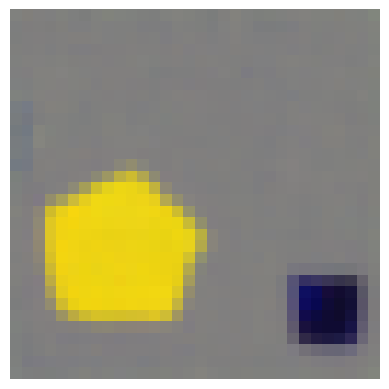

In [20]:

image = dalle2((3, IMG_SIZE, IMG_SIZE), "a small black square and a large gold pentagon", cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())

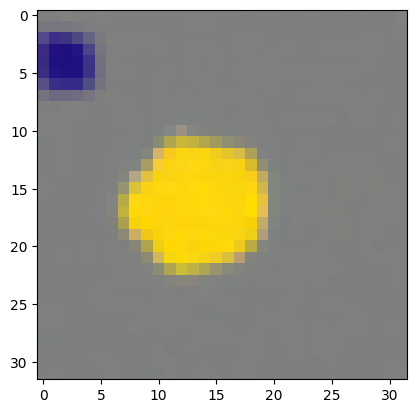

In [73]:

image = dalle2((3, IMG_SIZE, IMG_SIZE), "a small black square and a large gold pentagon", cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())

In [71]:
import pandas as pd
pd.unique(train_data.captions).shape

(10418,)

In [17]:
idx = 3
image = img[None, idx]
text = txt[idx]

print(text)

a black rectangle


In [48]:
sys.path.insert(0, 'nn_components')
from tokenizer import tokenize

text_tokens = tokenize(text, context_length=dalle2.clip.context_length)
text_tokens = text_tokens.to(device=dalle2.device)
text_embedding = dalle2.clip.encode_text(text_tokens, normalize=True)
image_embedding = dalle2.prior.sample(text_embedding, text_encodings=text_tokens)

In [49]:
image_embedding_truth = dalle2.clip.encode_image(image.to(device=dalle2.device), normalize=True)

print(image_embedding)
print(image_embedding_truth)

tensor([[ 0.4166, -0.0312,  0.3619,  0.0209, -0.4754,  0.5349]],
       device='cuda:0')
tensor([[ 0.2169, -0.0241,  0.4038, -0.3160, -0.6890,  0.4634]],
       device='cuda:0')


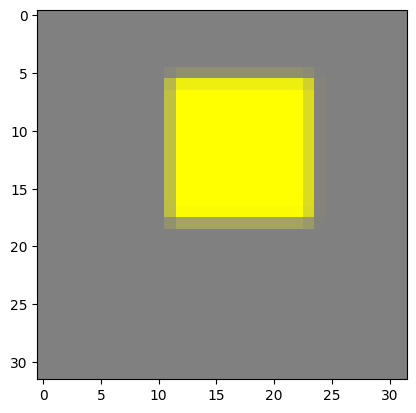

In [50]:
show_tensor_image(image)

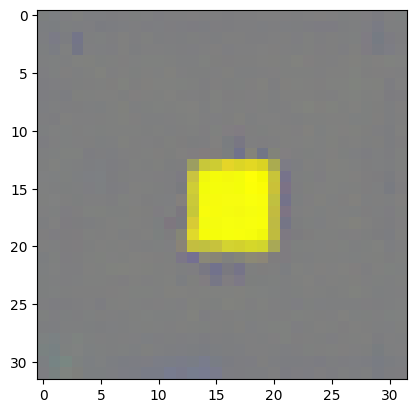

In [51]:
decoder = decoder.train()
img_pred = decoder.sample_one(IMG_DIM, text_tokens, clip_emb=image_embedding,cf_guidance_scale=2)
show_tensor_image(img_pred.detach().cpu())

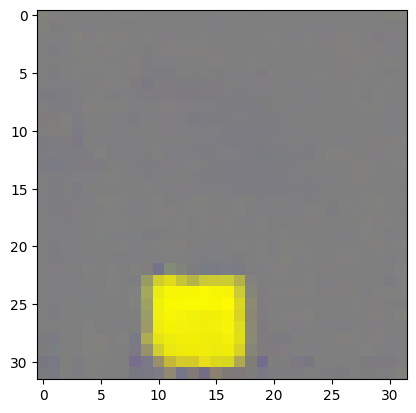

In [52]:
img_pred = decoder.sample_one(IMG_DIM, text_tokens, clip_emb=image_embedding_truth,cf_guidance_scale=2)
show_tensor_image(img_pred.detach().cpu())

In [31]:
@torch.no_grad()
def sample_plot_image(decoder: Decoder, tokens, clip_emb, diffusion: Diffusion, guidance_scale=GUIDANCE_SCALE, **kwargs):
    # model.eval()
    assert tokens.shape == (1, CONTEXT_LENGTH)
    # Sample noise
    img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
    fig = plt.figure(figsize=(15,6))
    plt.axis('off')

    num_images = 10
    stepsize = int(T/num_images)

    title = kwargs["caption"]
    assert clip_emb.shape == (1, CLIP_EMB_DIM)

    plt.title(title)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = decoder.sample_timestep(img, t, tokens, clip_emb, cf_guidance_scale=guidance_scale)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            fig.add_subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

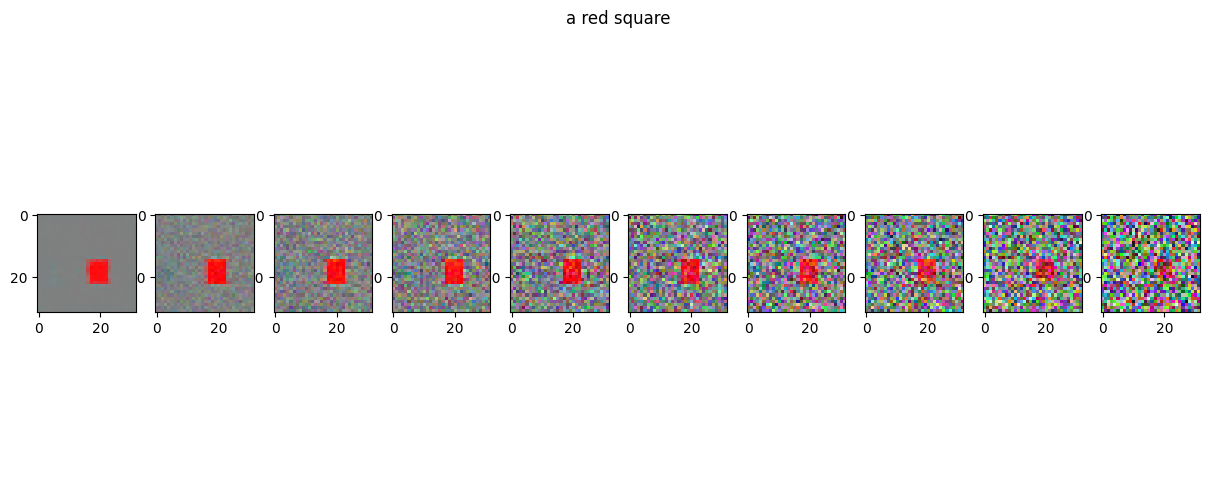

In [38]:
sample_plot_image(decoder, text_tokens, image_embedding_truth, decoder_diffusion, guidance_scale=2, caption=text)

# KNN

In [12]:
from sklearn.neighbors import NearestNeighbors

def knn(x, xs, k=5, metric="euclidean"):
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(xs)
    distances, indices = nbrs.kneighbors(x)
    return distances, indices

In [13]:
import tqdm
from nn_components.tokenizer import tokenize

image_embeddings = []
text_embeddings = []
with torch.no_grad():
    for step, (img, txt) in enumerate(dataloader):
        img = img.to(device=dalle2.device)
        img_emb = dalle2.clip.encode_image(img, normalize=True)
        image_embeddings.append(img_emb.detach().cpu().numpy())

        txt = tokenize(txt, context_length=dalle2.clip.context_length)
        txt = txt.to(device=dalle2.device)
        txt_emb = dalle2.clip.encode_text(txt, normalize=True)
        text_embeddings.append(txt_emb.detach().cpu().numpy())

In [14]:
from functools import reduce

image_embeddings = reduce(lambda x, y: np.concatenate((x, y)), image_embeddings)
text_embeddings = reduce(lambda x, y: np.concatenate((x, y)), text_embeddings)


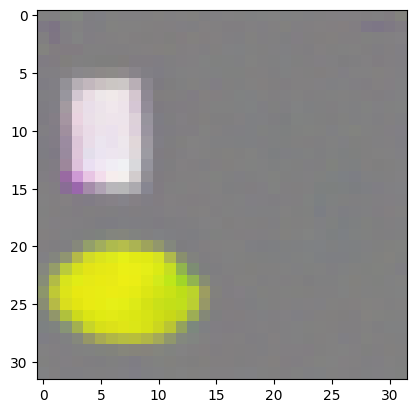

In [117]:
image = dalle2((3, IMG_SIZE, IMG_SIZE), "a white rectangle and a yellow ellipse", cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())

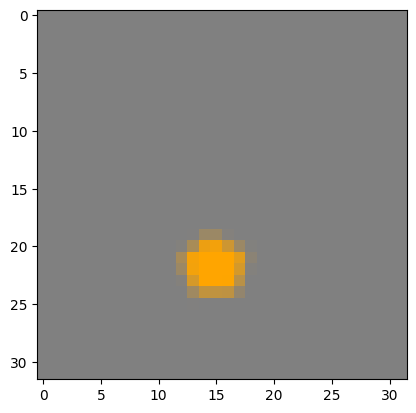

In [110]:

image = train_data[88][0][None, :, :, :]
show_tensor_image(image)

11567


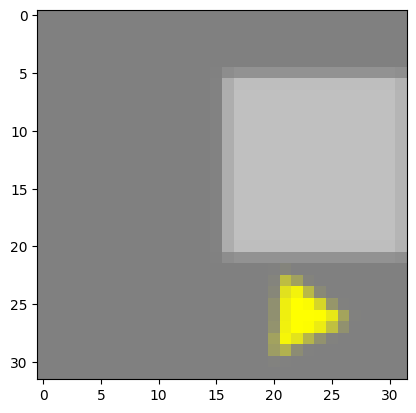

1424


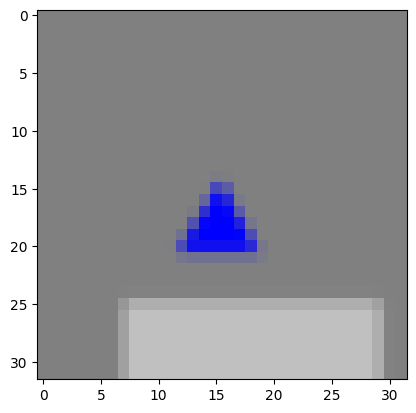

11575


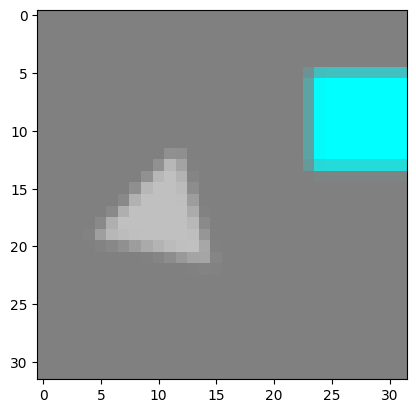

11770


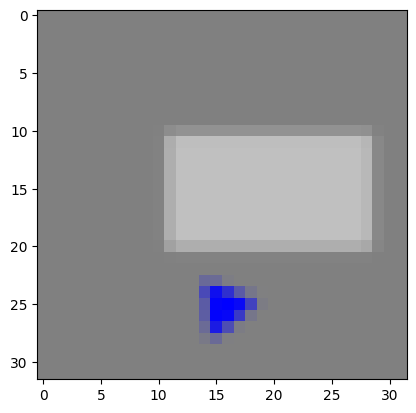

1713


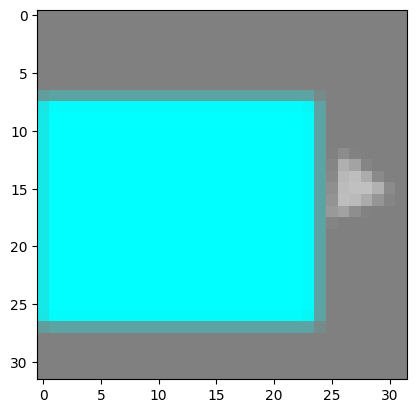

In [118]:
image_embedding = dalle2.clip.encode_image(image.to(device=dalle2.device), normalize=True)
image_embedding = image_embedding.detach().cpu().numpy()
_, indices = knn(image_embedding, image_embeddings, k=5, metric="euclidean")
for i in indices[0]:
    print(i)
    show_tensor_image(train_data[i][0])
    plt.show()

In [119]:
print(image_embedding)
# print(image_embeddings[indices[0][0]])
print(image_embeddings[11567])

[[-2.21415400e-03  3.84702869e-02  1.91590209e-02 -1.29403025e-01
   2.08721142e-02  7.84545317e-02  7.22459331e-02 -4.36300114e-02
  -2.53236550e-03  4.37679477e-02 -8.58548004e-03 -2.54510995e-02
   1.46583300e-02  8.16021040e-02  1.23583734e-01 -6.04330860e-02
   6.88675344e-02  3.49217393e-02  4.34978046e-02 -4.26559635e-02
   1.41582955e-02  2.58016214e-03  4.37681116e-02  8.51965621e-02
   5.54014817e-02 -3.59445028e-02 -4.96664084e-02  3.71118039e-02
  -6.33530766e-02  3.30435559e-02  2.77439877e-02  2.45364636e-01
   5.83640598e-02  1.08500049e-01 -7.67985359e-02 -6.57600388e-02
  -9.73851010e-02 -1.92199796e-02 -2.33550090e-02  9.50873569e-02
   3.50309275e-02  1.98424328e-02 -2.22428627e-02  1.29935136e-02
   3.81428674e-02 -6.29486144e-02  3.82073224e-02  2.74566971e-02
  -7.07880966e-03 -7.09944442e-02 -4.12776396e-02 -3.06055807e-02
   4.16591987e-02  3.35150063e-02 -1.35172000e-02  1.35312220e-02
   4.79028560e-02 -2.73467917e-02  6.91024438e-02  2.87091499e-03
   3.79242

In [48]:
def cosine_similarity(x, y):
    return np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [120]:
print(cosine_similarity(image_embedding, image_embeddings[11567]))

[0.83047163]


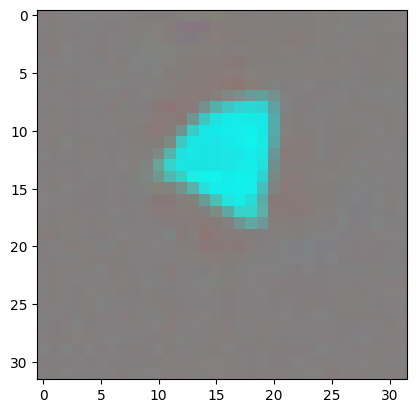

In [61]:
image = dalle2((3, IMG_SIZE, IMG_SIZE), "a large cyan triangle", cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())

9779


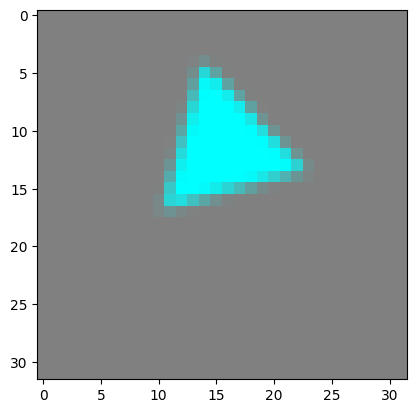

13819


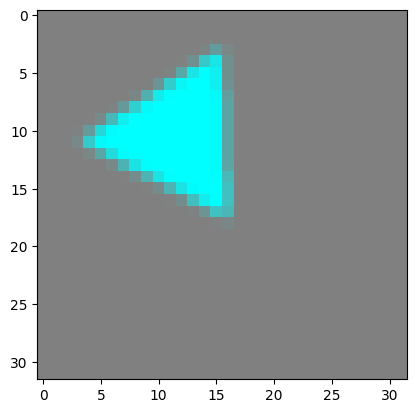

2405


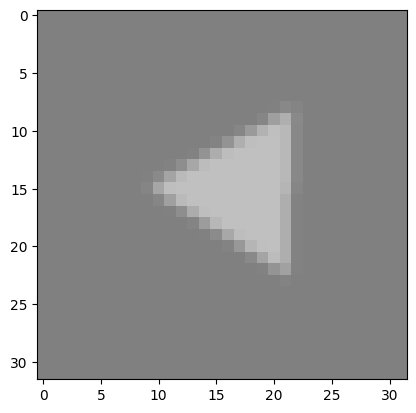

7189


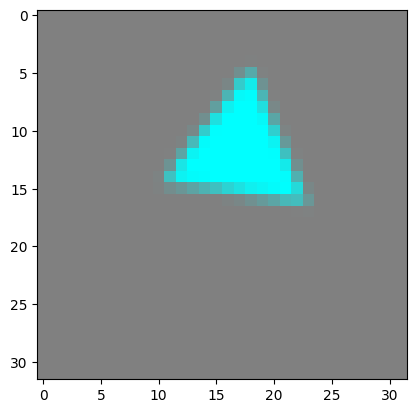

8699


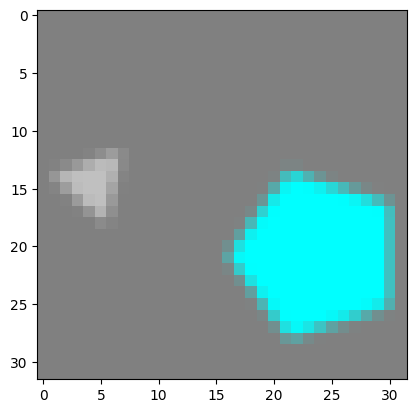

In [62]:
image_embedding = dalle2.clip.encode_image(image.to(device=dalle2.device), normalize=True)
image_embedding = image_embedding.detach().cpu().numpy()
_, indices = knn(image_embedding, image_embeddings, k=5, metric="euclidean")
for i in indices[0]:
    print(i)
    show_tensor_image(train_data[i][0])
    plt.show()

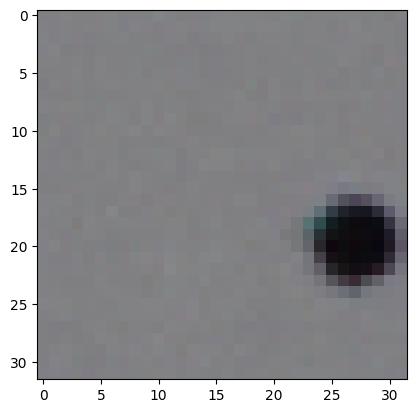

In [121]:
image = dalle2((3, IMG_SIZE, IMG_SIZE), "a circle", cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())

# PCA

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [29]:
def search(caption, train_data):
    captions = train_data.captions
    f1 = captions.str.endswith(caption)
    f2 = ~captions.str.contains("and")
    f = f1 & f2
    return f.to_numpy()

def search_and(caption1, caption2, train_data):
    captions = train_data.captions
    f1 = captions.str.contains(caption1)
    f2 = captions.str.contains(caption2)
    f = f1 & f2
    return f.to_numpy()

In [44]:
mc = search("magenta circle", train_data)
me = search("magenta ellipse", train_data)
mt = search("magenta triangle", train_data)
gr = search("green rectangle", train_data)
mr = search("magenta rectangle", train_data)
ms = search("magenta square", train_data)
bt = search("blue triangle", train_data)
mc_gr = search_and("magenta triangle", "green rectangle", train_data)


[0.12255374 0.10073951]


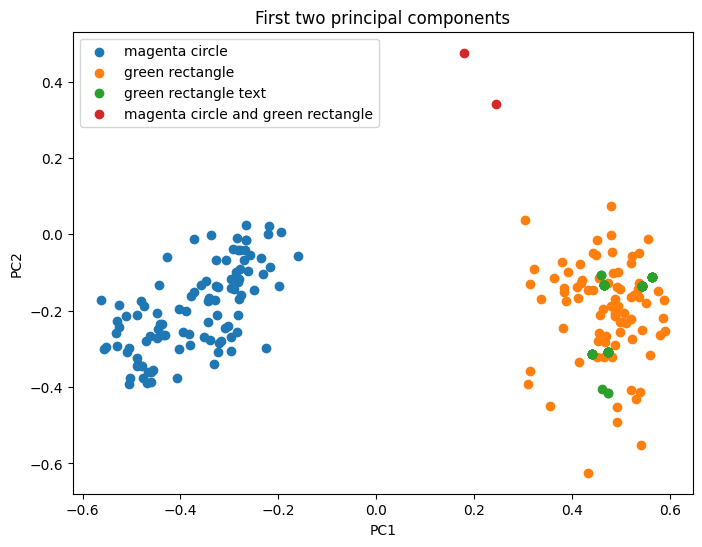

In [45]:
pca = PCA(n_components=2)
plt.figure(figsize=(8,6))
Xi = pca.fit_transform(image_embeddings)
Xt = pca.transform(text_embeddings)

# Xt = pca.fit_transform(text_embeddings)
# Xi = pca.transform(image_embeddings)
print(pca.explained_variance_ratio_)

plot = plt.scatter(Xi[mc,0], Xi[mc,1], label="magenta circle")
# plt.scatter(Xt[mc,0], Xt[mc,1], label="magenta circle text")
# plt.scatter(Xi[me,0], Xi[me,1], label="magenta ellipse")
# plt.scatter(Xi[mt,0], Xi[mt,1], label="magenta triangle")
# plt.scatter(Xi[bt,0], Xi[bt,1], label="blue triangle")
plt.scatter(Xi[gr,0], Xi[gr,1], label="green rectangle")
plt.scatter(Xt[gr,0], Xt[gr,1], label="green rectangle text")
plt.scatter(Xi[mc_gr,0], Xi[mc_gr,1], label="magenta circle and green rectangle")
# plt.scatter(Xi[mr,0], Xi[mr,1], label="magenta rectangle")
# plt.scatter(Xi[ms,0], Xi[ms,1], label="magenta square")
# plt.legend(handles=plot.legend_elements()[0])
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components")
plt.show()

[0.12311831 0.10044894]


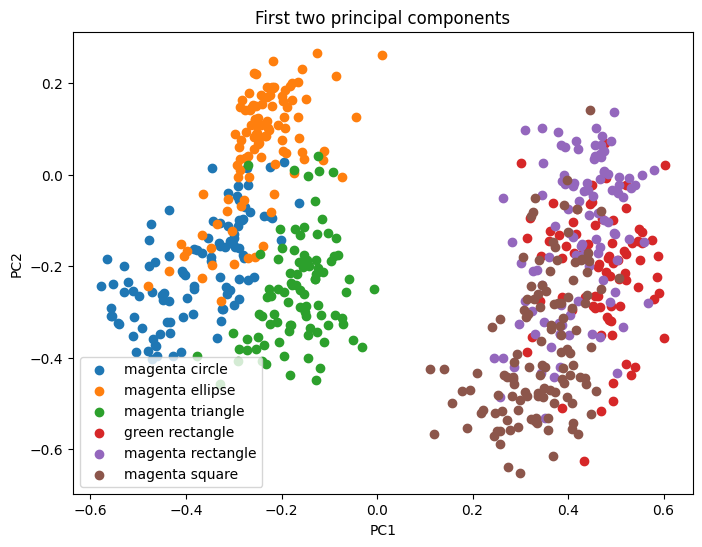

In [40]:
pca = PCA(n_components=2)
plt.figure(figsize=(8,6))
Xi = pca.fit_transform(image_embeddings)
print(pca.explained_variance_ratio_)
plot = plt.scatter(Xi[mc,0], Xi[mc,1], label="magenta circle")
plt.scatter(Xi[me,0], Xi[me,1], label="magenta ellipse")
plt.scatter(Xi[mt,0], Xi[mt,1], label="magenta triangle")
plt.scatter(Xi[gr,0], Xi[gr,1], label="green rectangle")
plt.scatter(Xi[mr,0], Xi[mr,1], label="magenta rectangle")
plt.scatter(Xi[ms,0], Xi[ms,1], label="magenta square")
# plt.legend(handles=plot.legend_elements()[0])
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components")
plt.show()

[0.11476801 0.09529234]


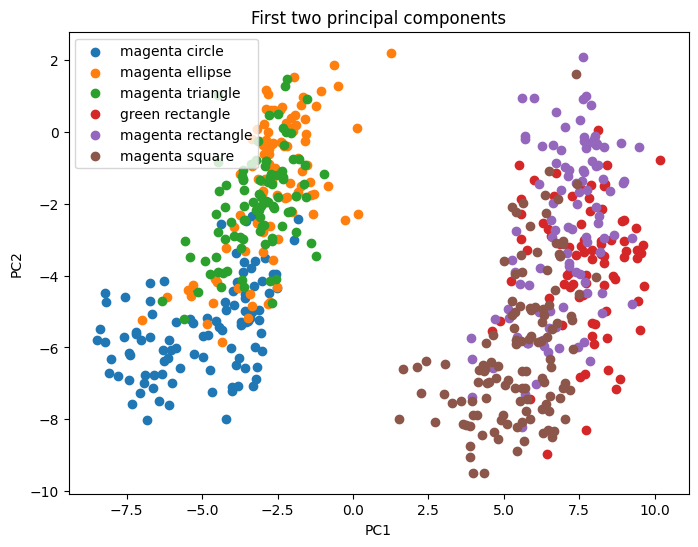

In [43]:
pca = PCA(2)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
plt.figure(figsize=(8,6))
Xi = pipe.fit_transform(image_embeddings)
print(pca.explained_variance_ratio_)
plot = plt.scatter(Xi[mc,0], Xi[mc,1], label="magenta circle")
plt.scatter(Xi[me,0], Xi[me,1], label="magenta ellipse")
plt.scatter(Xi[mt,0], Xi[mt,1], label="magenta triangle")
plt.scatter(Xi[gr,0], Xi[gr,1], label="green rectangle")
plt.scatter(Xi[mr,0], Xi[mr,1], label="magenta rectangle")
plt.scatter(Xi[ms,0], Xi[ms,1], label="magenta square")
# plt.legend(handles=plot.legend_elements()[0])
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components")
plt.show()

[0.11476793 0.09529217]


/vol/bitbucket/hl3919/miniconda3/envs/fyp/lib/python3.8/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


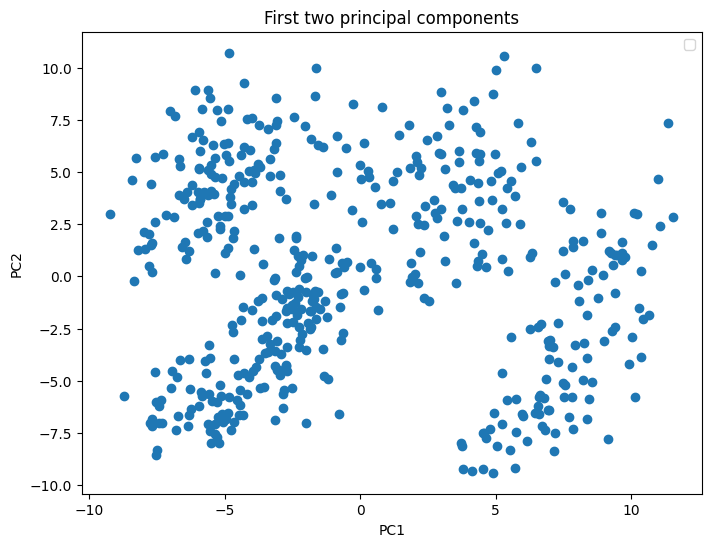

In [22]:
pca = PCA(n_components=2)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
plt.figure(figsize=(8,6))
Xi = pipe.fit_transform(image_embeddings)
print(pca.explained_variance_ratio_)
plot = plt.scatter(Xi[:500,0], Xi[:500,1])
plt.legend(handles=plot.legend_elements()[0])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components")
plt.show()

# Guidance Scale

In [ ]:
def generate_images(n, cf_guidance_scale, all_captions):
    images = []
    captions = []
    for i in range(n):
        caption = np.random.choice(all_captions)
        captions.append(caption)
        image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=cf_guidance_scale)
        images.append(image.detach().cpu())
        if i % 10 == 0:
            print(i)

In [74]:
images = []
captions = []
all_captions = pd.unique(train_data.captions)
for i in range(1000):
    caption = np.random.choice(all_captions)
    captions.append(caption)
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=2)
    images.append(image.detach().cpu())
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [83]:
for i in range(len(images)):
    filename = f"{i}.png"
    image = reverse_transforms(images[i].squeeze(0))
    image.save(f"evaluations/v3/cf2/normal/images/{filename}.png")

In [85]:
cs = pd.DataFrame({"caption": captions})
cs.to_csv("evaluations/v3/cf2/normal/captions.csv")

In [87]:
import torch_fidelity

metrics_dict = torch_fidelity.calculate_metrics(
    input1="data3/train/images", 
    input2="data3/train/images", 
    cuda=True, 
    isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=False,
)

/vol/bitbucket/hl3919/miniconda3/envs/fyp/lib/python3.8/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


In [88]:
metrics_dict

{'inception_score_mean': 2.3622372398183273,
 'inception_score_std': 0.03377852815792885,
 'frechet_inception_distance': 2.0179413695586845e-12,
 'kernel_inception_distance_mean': -4.624631381381583e-05,
 'kernel_inception_distance_std': 9.018269641806845e-05}

In [26]:
data_transforms = [
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.PILToTensor()
    # transforms.ToTensor(), # Scales data into [0,1]
    # transforms.RandomRotation(degrees=180, fill=128),
    # transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
]
data_transform = transforms.Compose(data_transforms)

train_data.image_only(True)
train_data.transform = data_transform

test_data.image_only(True)
test_data.transform = data_transform

In [40]:
for i in range(len(train_data)):
    image = transforms.ToPILImage()(train_data[i])
    image.save(f"evaluations/v3/reference/normal/images/train_{i}.png")
    

In [30]:
caption = "a large cyan pentagon and a red ellipse"

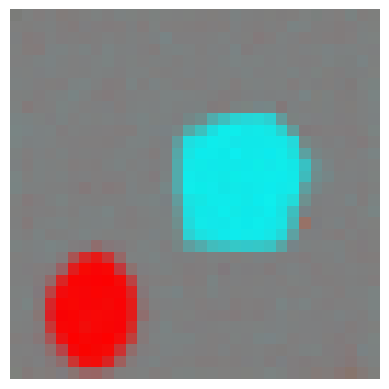

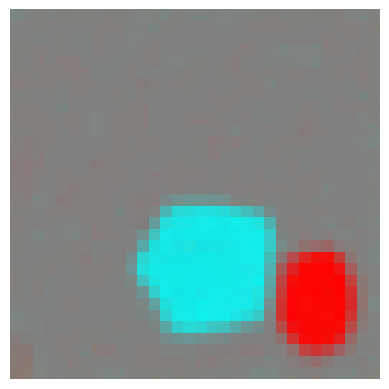

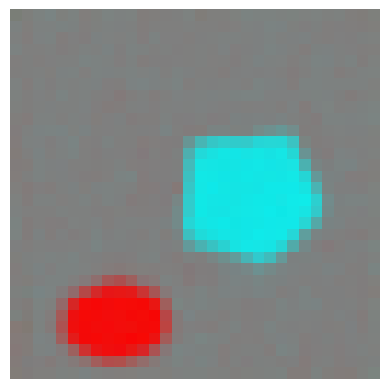

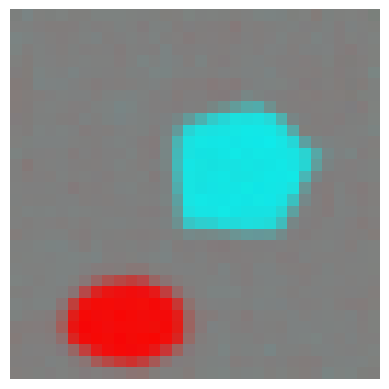

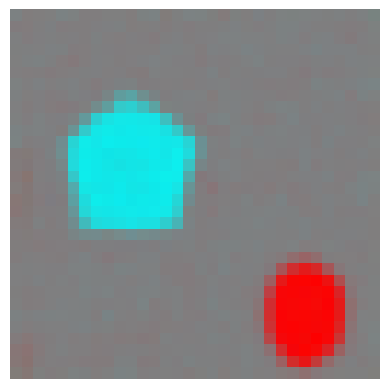

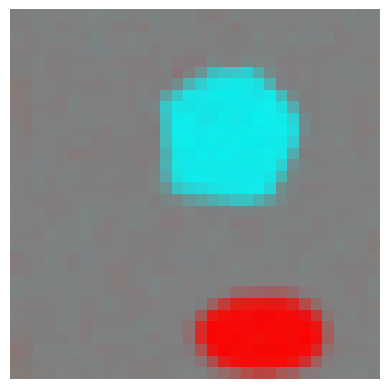

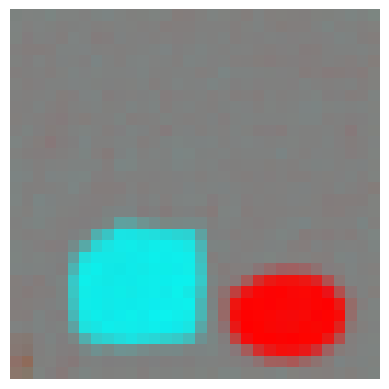

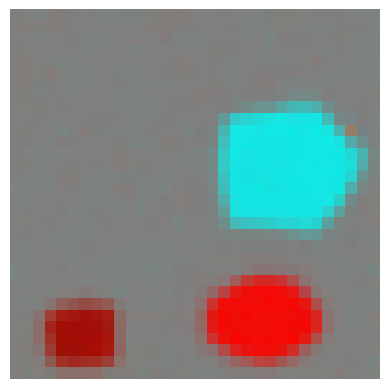

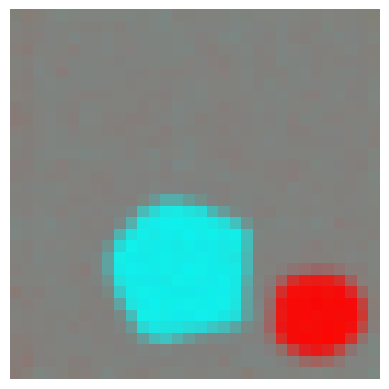

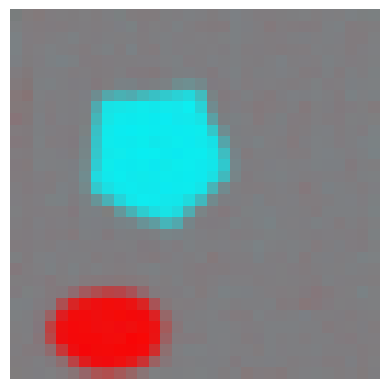

In [31]:
torch.manual_seed(4)
for i in range(10):
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=1)
    show_tensor_image(image.detach().cpu())

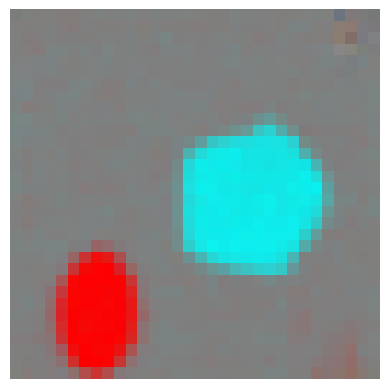

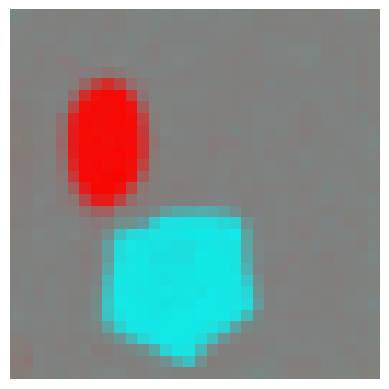

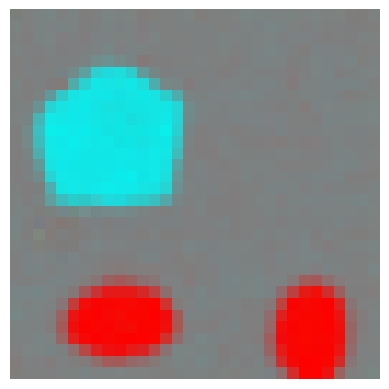

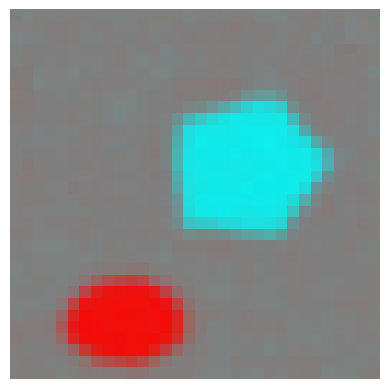

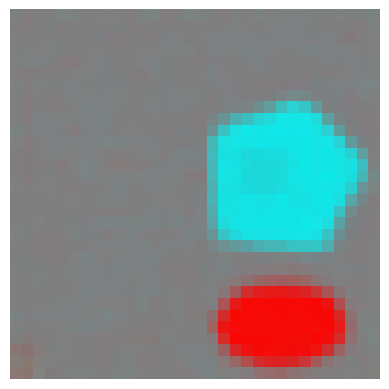

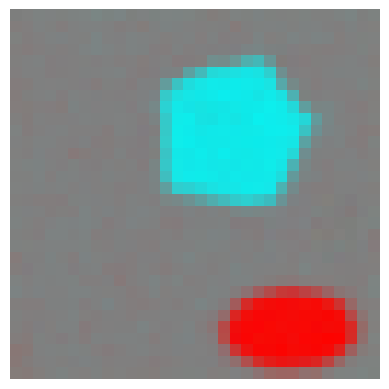

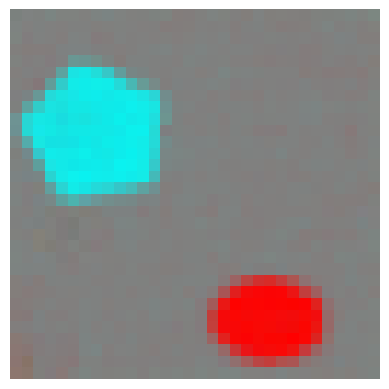

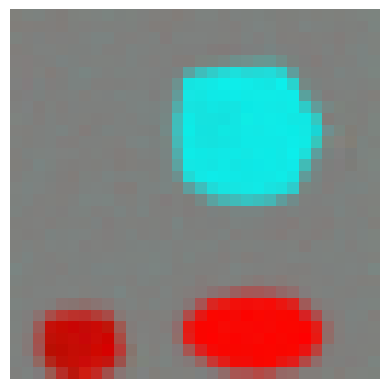

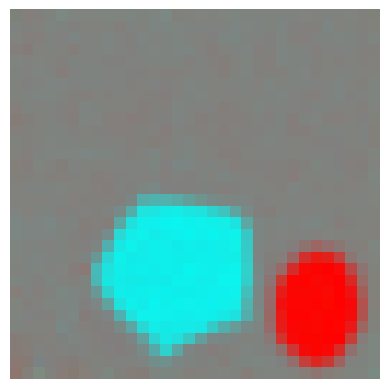

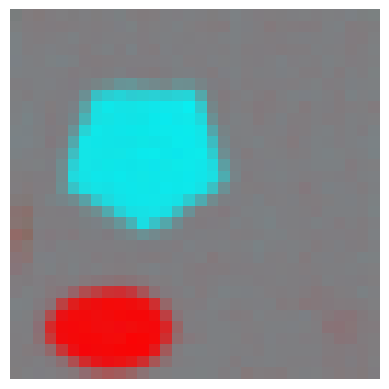

In [24]:
torch.manual_seed(4)
for i in range(10):
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=2)
    show_tensor_image(image.detach().cpu())

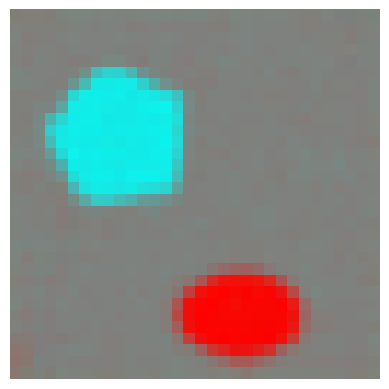

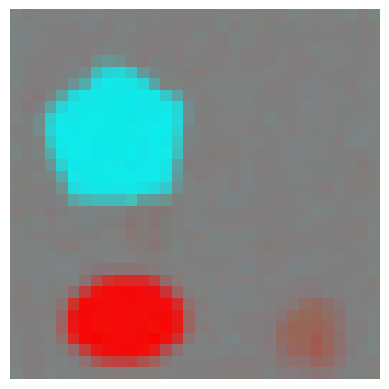

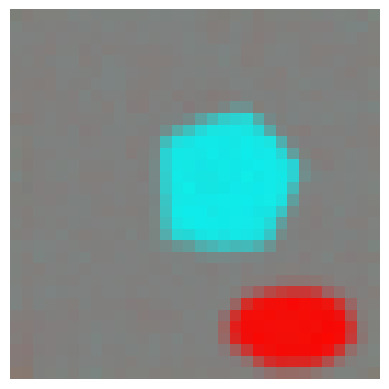

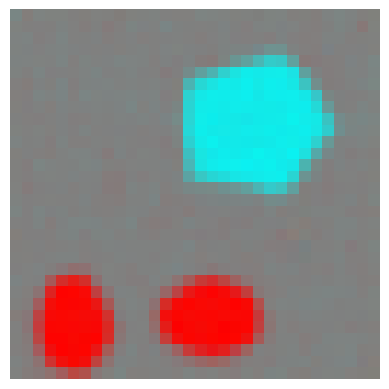

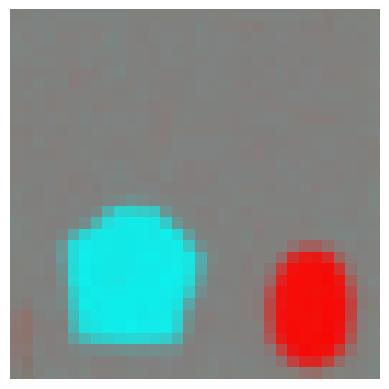

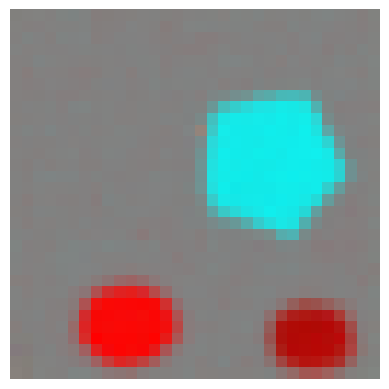

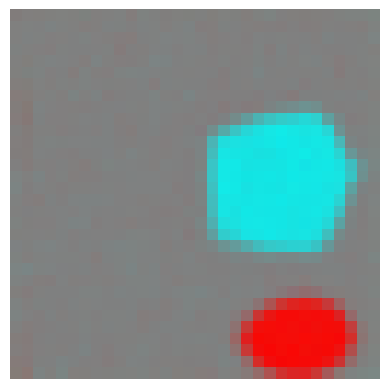

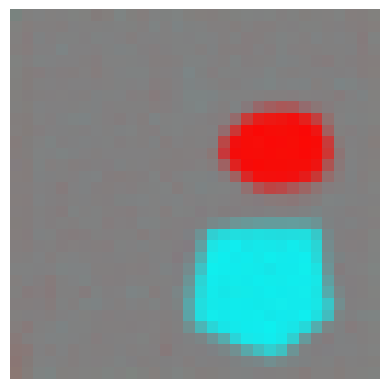

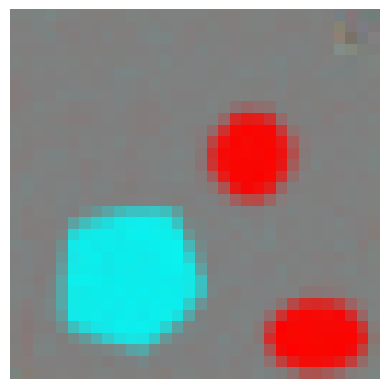

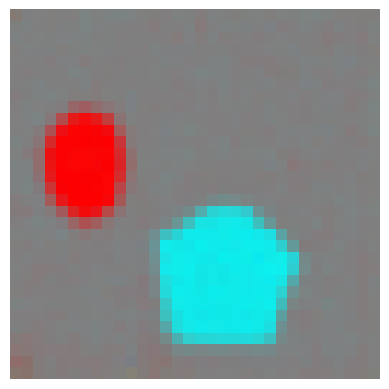

In [25]:
torch.manual_seed(0)
for i in range(10):
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=1.5)
    show_tensor_image(image.detach().cpu())

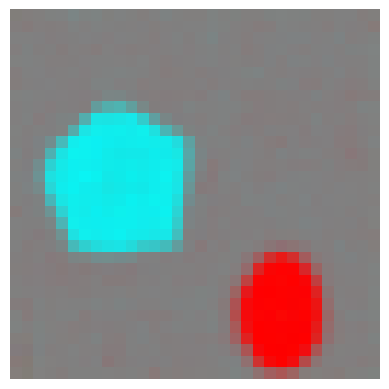

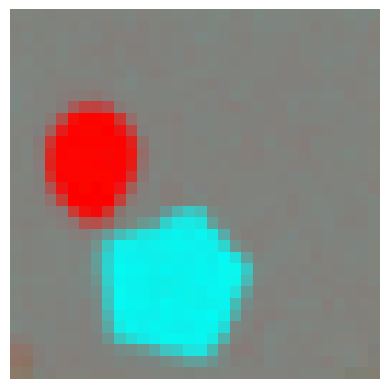

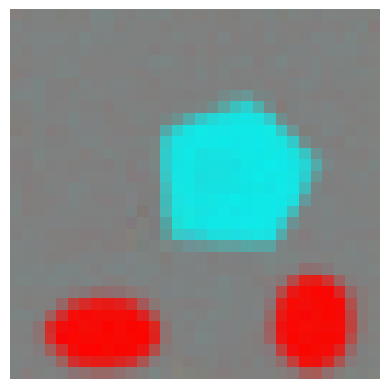

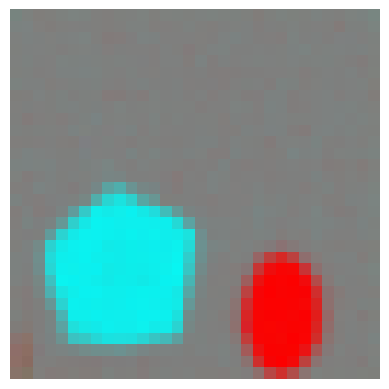

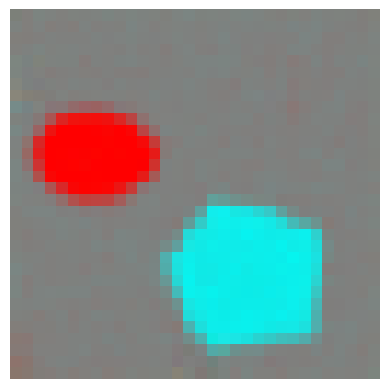

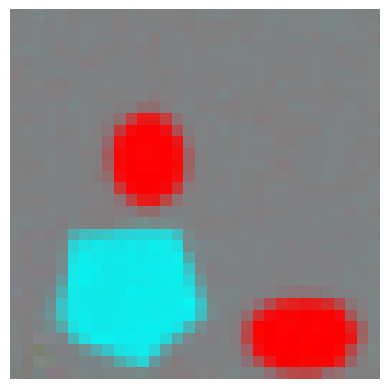

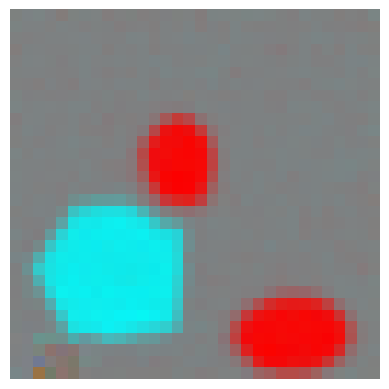

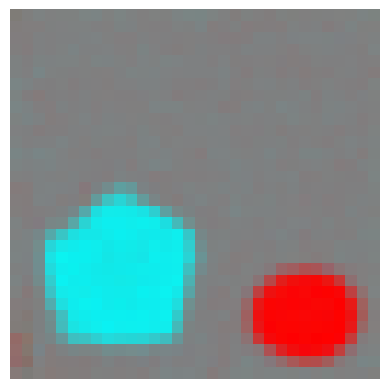

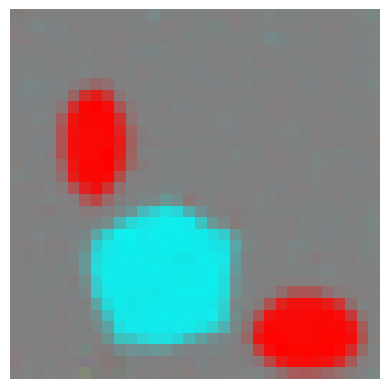

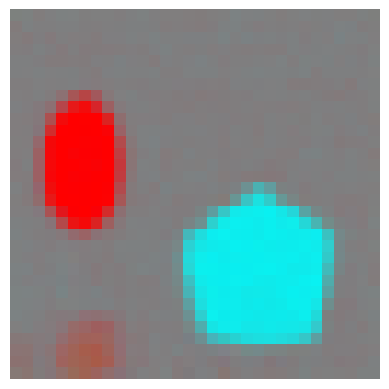

In [33]:
torch.manual_seed(3432)
for i in range(10):
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=2)
    show_tensor_image(image.detach().cpu())

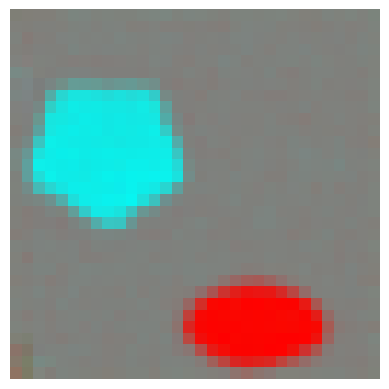

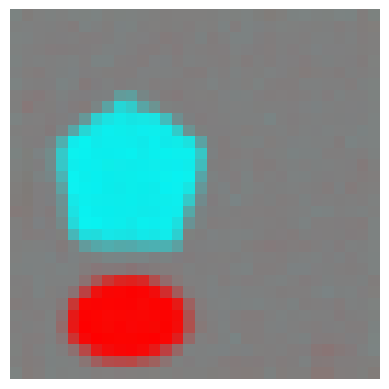

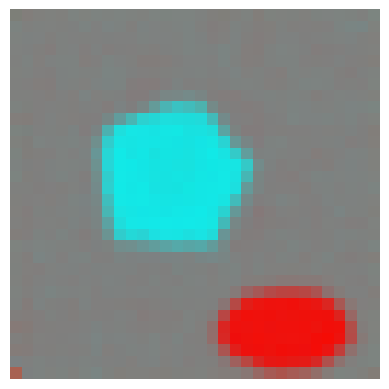

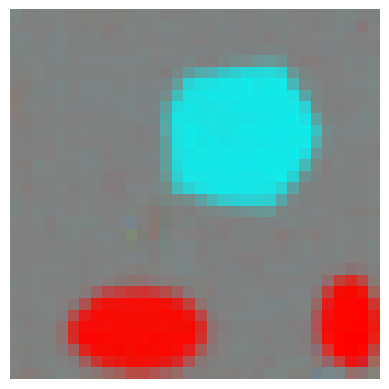

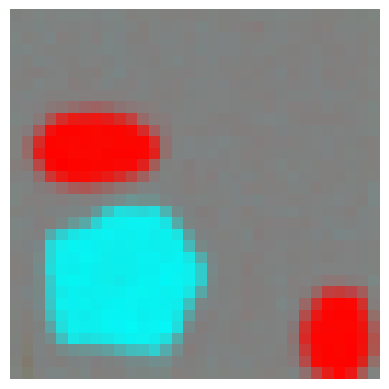

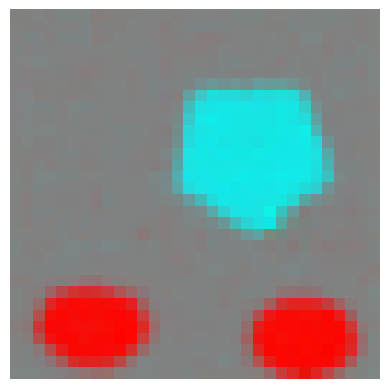

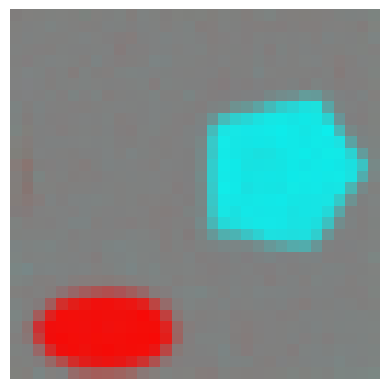

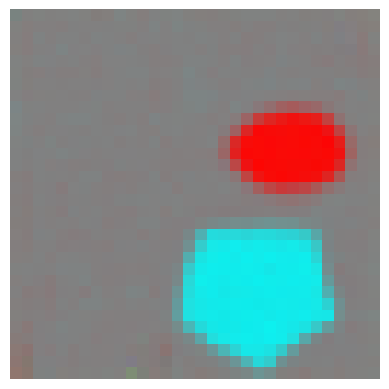

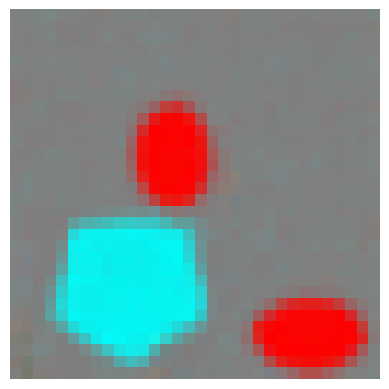

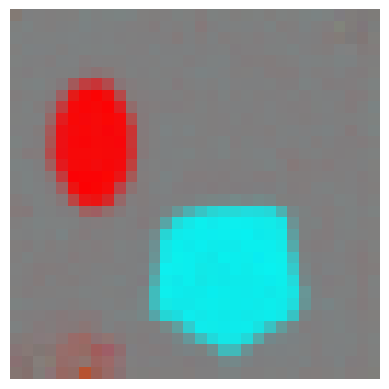

In [27]:
torch.manual_seed(0)
for i in range(10):
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=2.5)
    show_tensor_image(image.detach().cpu())

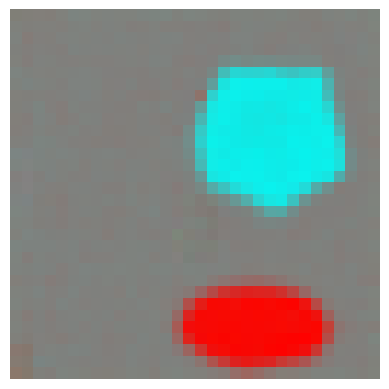

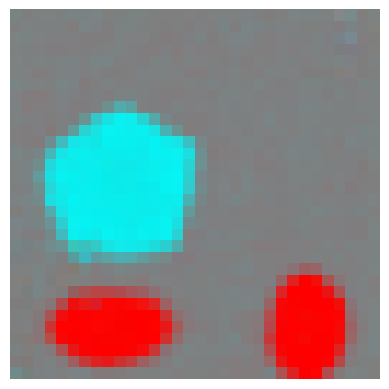

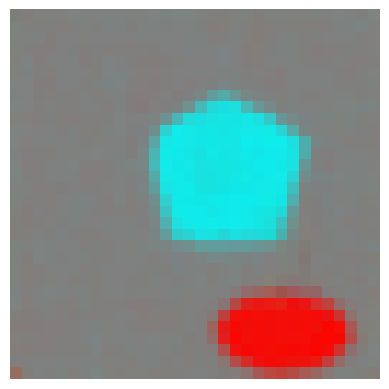

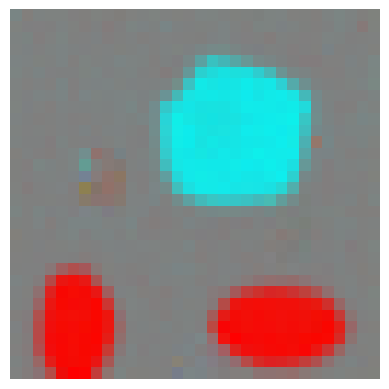

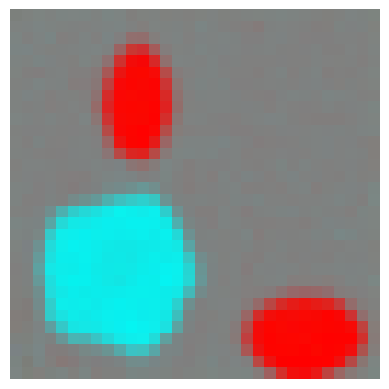

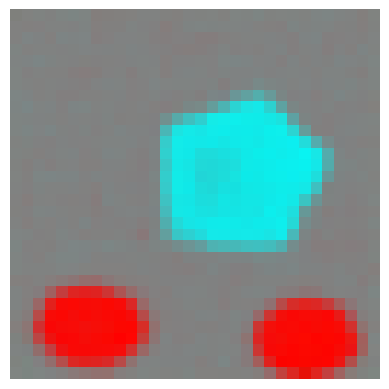

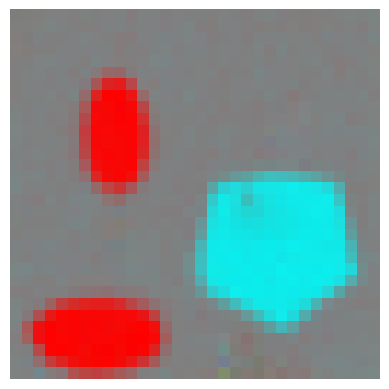

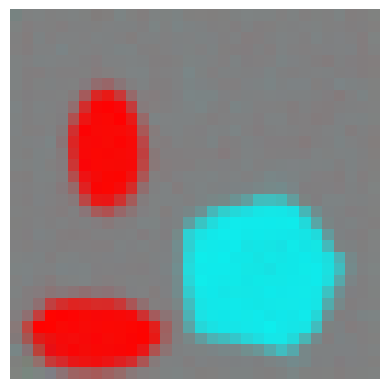

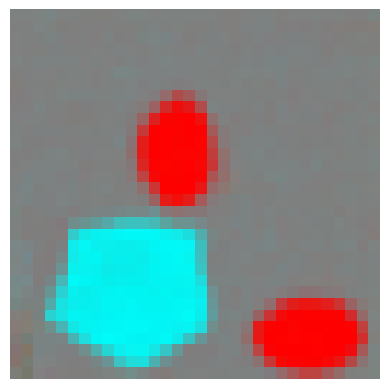

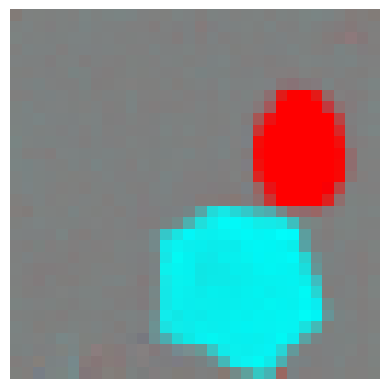

In [28]:
torch.manual_seed(0)
for i in range(10):
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=3)
    show_tensor_image(image.detach().cpu())

1


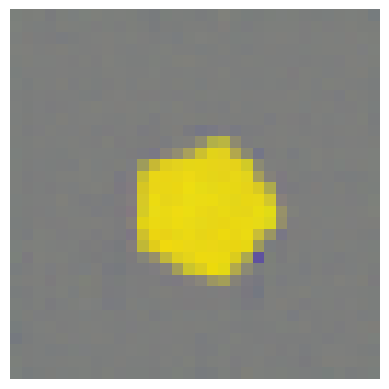

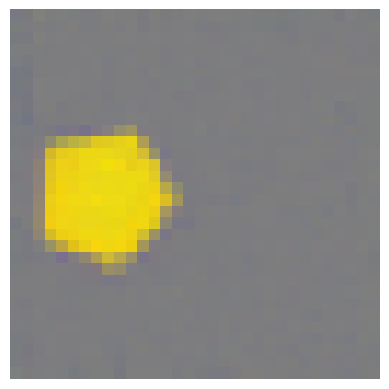

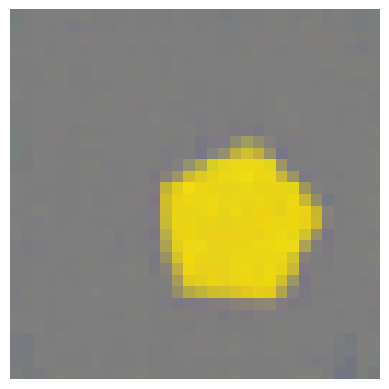

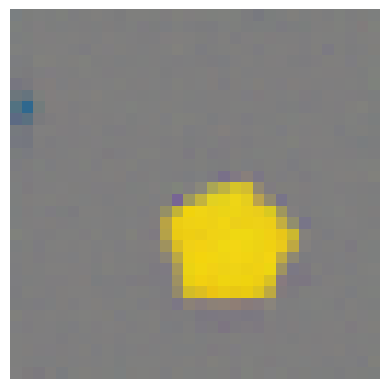

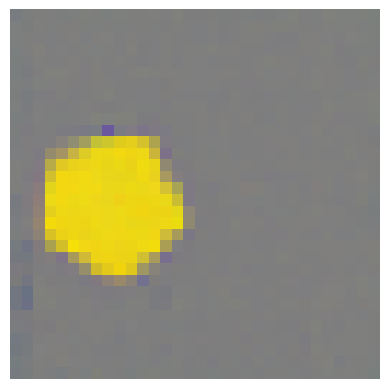

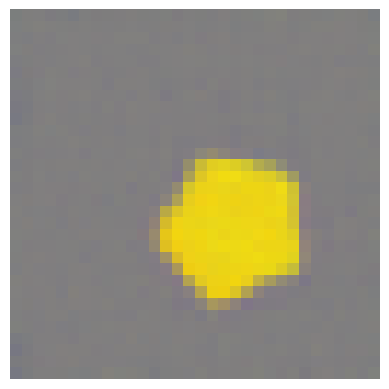

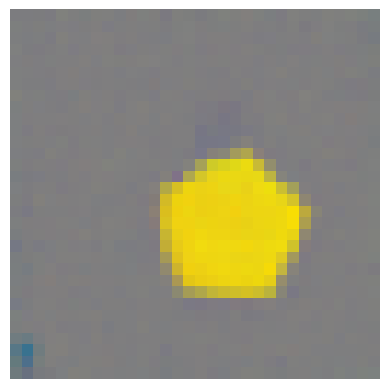

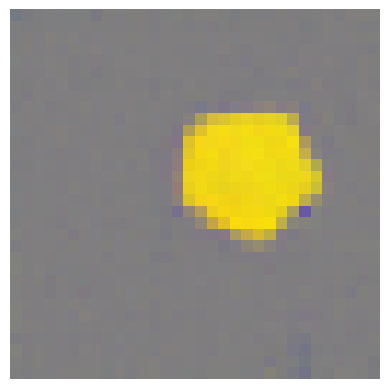

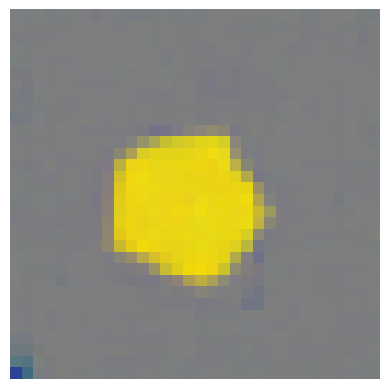

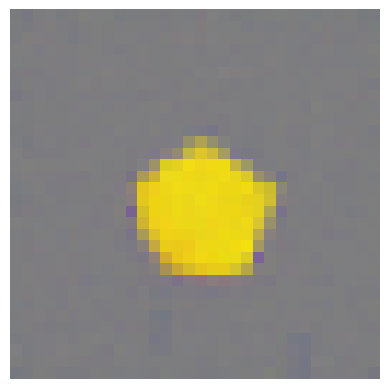

1.5


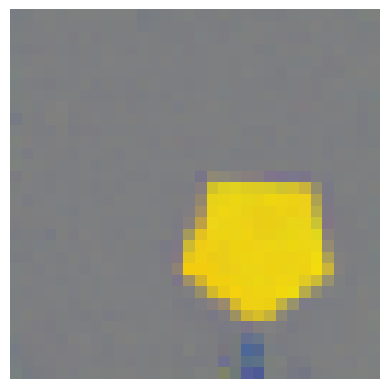

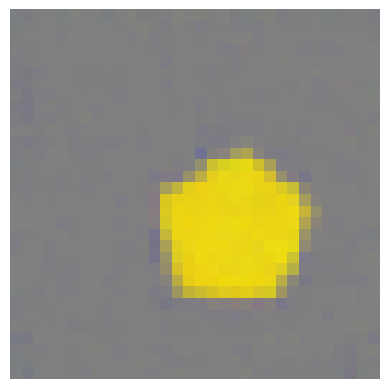

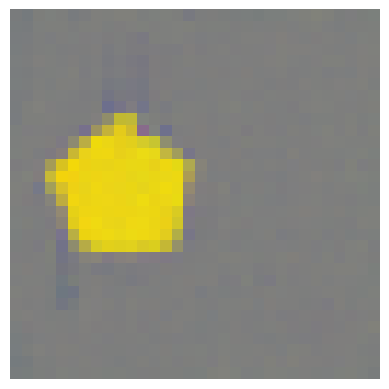

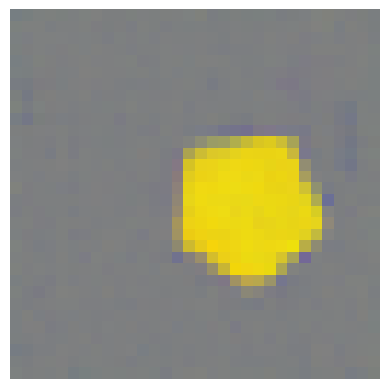

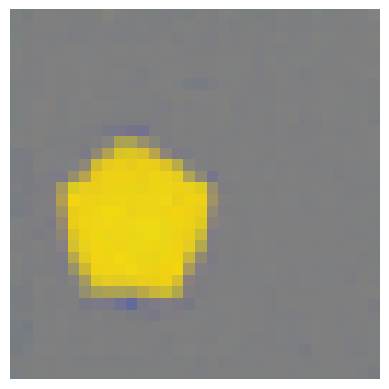

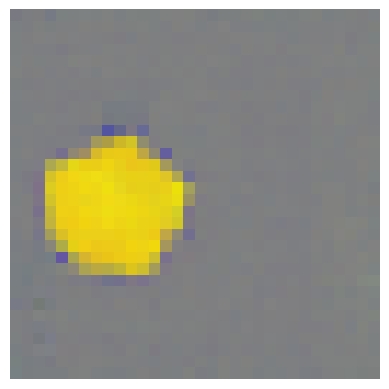

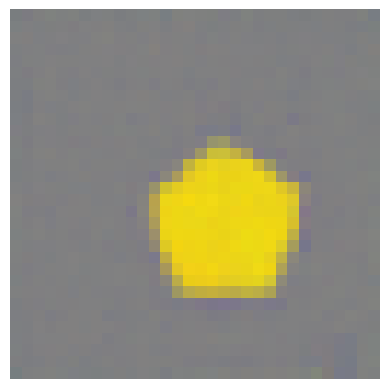

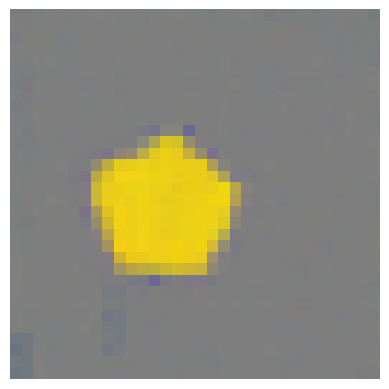

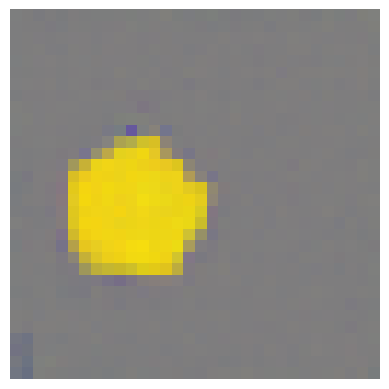

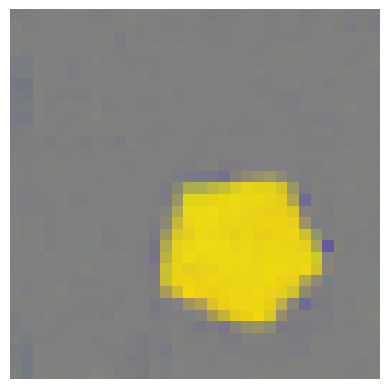

2


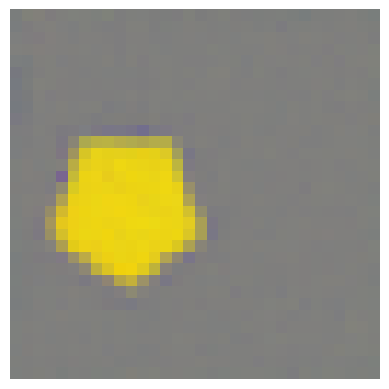

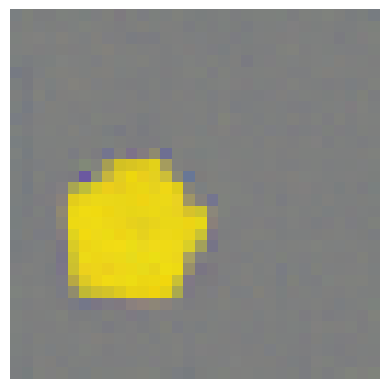

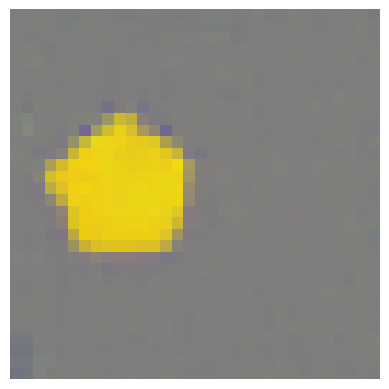

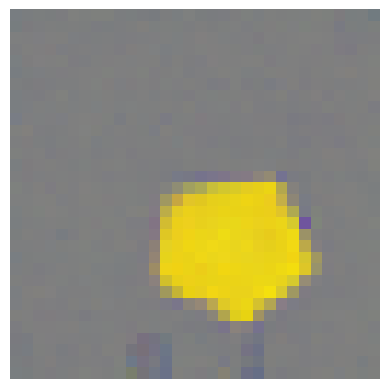

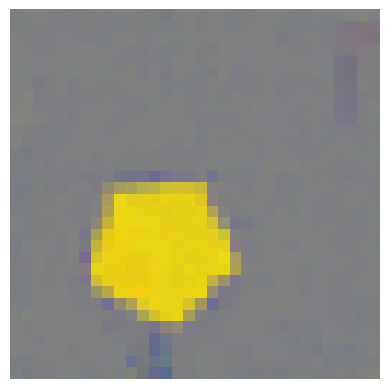

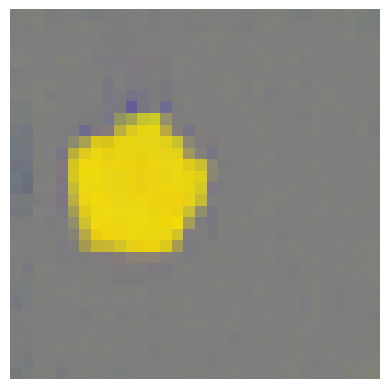

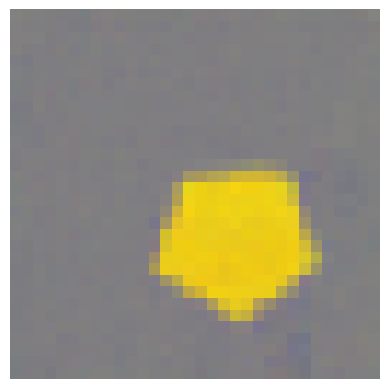

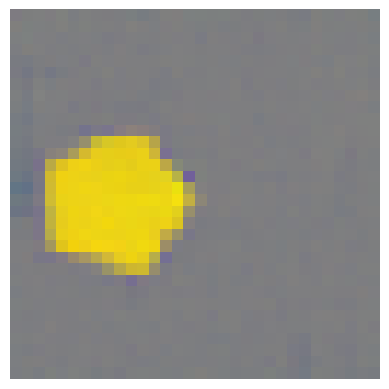

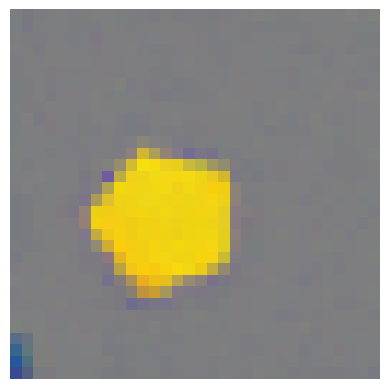

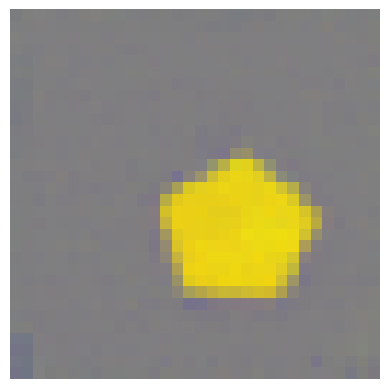

2.5


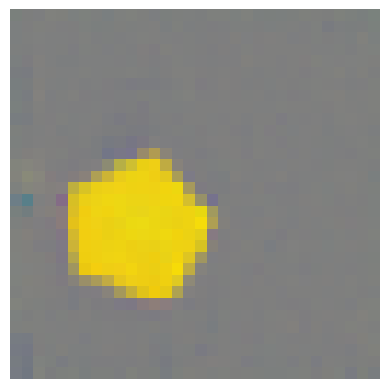

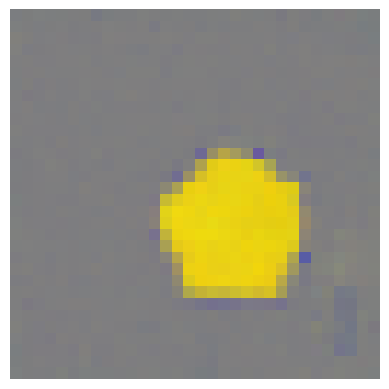

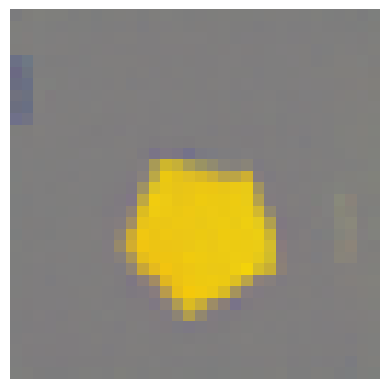

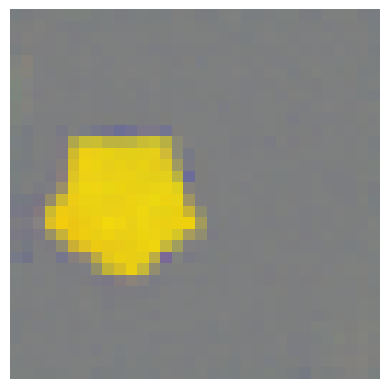

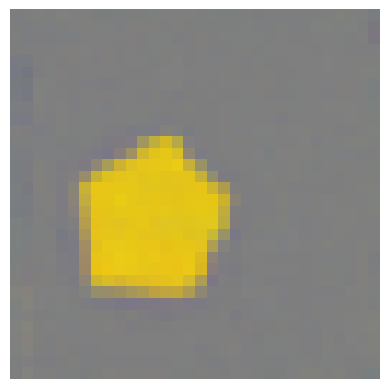

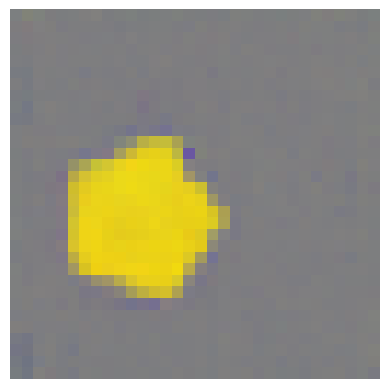

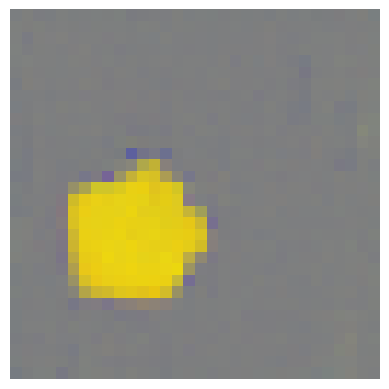

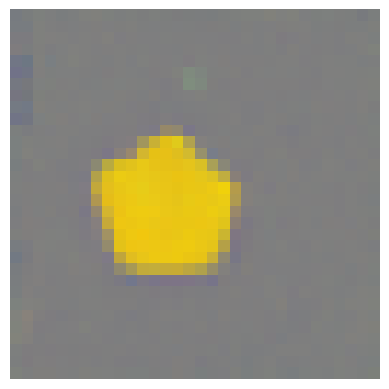

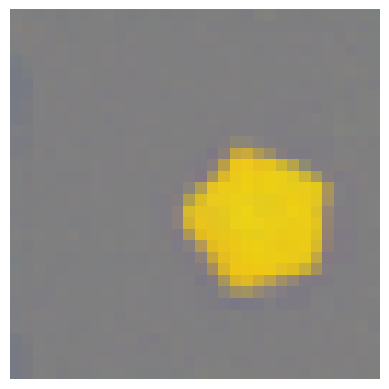

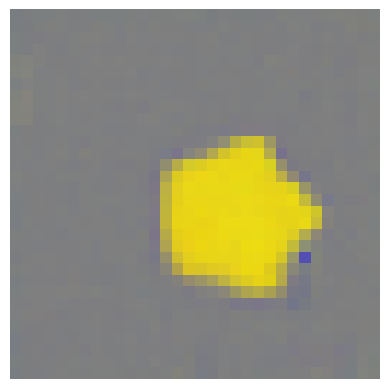

3


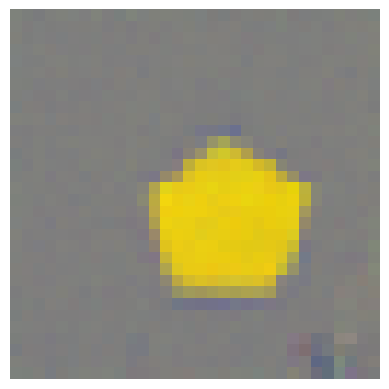

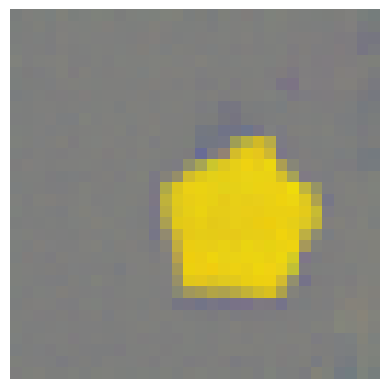

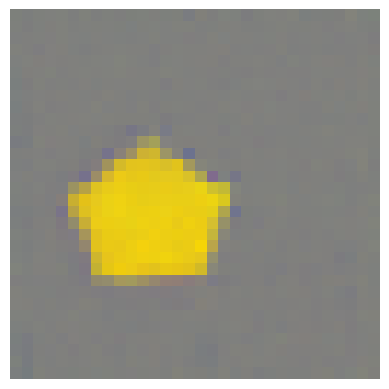

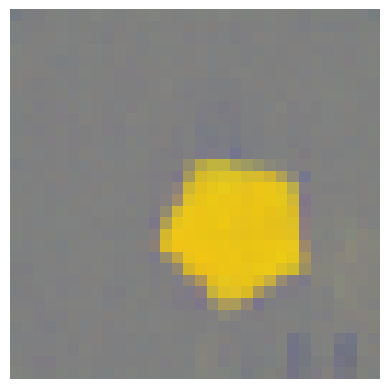

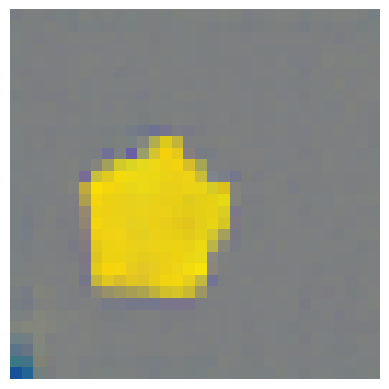

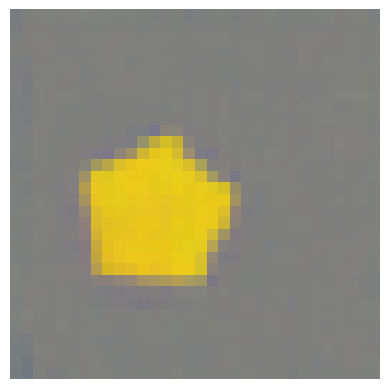

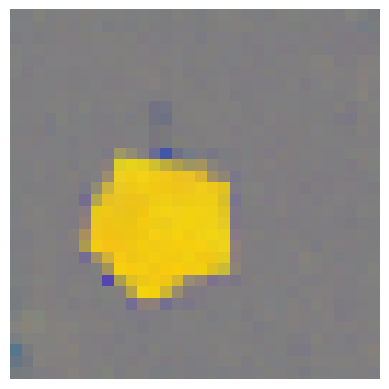

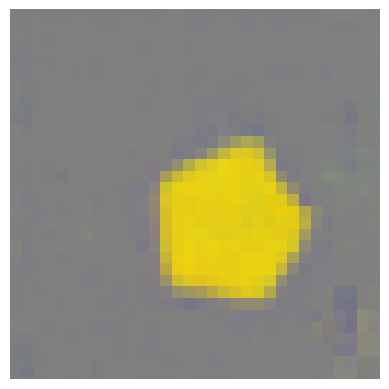

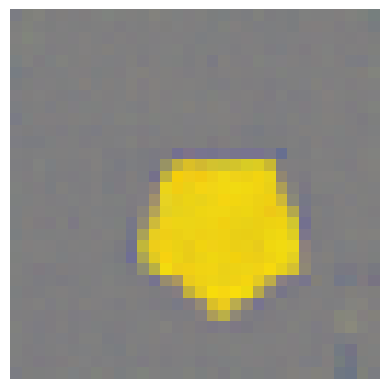

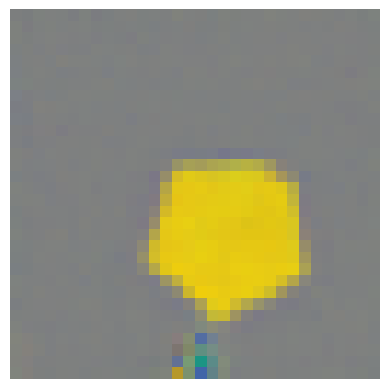

In [29]:
caption = "a large gold pentagon"


torch.manual_seed(0)
print(1)
for i in range(10):
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=1)
    show_tensor_image(image.detach().cpu())

print(1.5)
for i in range(10):
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=1.5)
    show_tensor_image(image.detach().cpu())

print(2)
for i in range(10):
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=2)
    show_tensor_image(image.detach().cpu())

print(2.5)
for i in range(10):
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=2.5)
    show_tensor_image(image.detach().cpu())


print(3)
for i in range(10):
    image = dalle2((3, IMG_SIZE, IMG_SIZE), caption, cf_guidance_scale=3)
    show_tensor_image(image.detach().cpu())

In [11]:
import torch_fidelity

In [100]:
torch_fidelity.calculate_metrics(
    input1="evaluations/v3/cf1/images", 
    input2="evaluations/v3/reference/normal/images", 
    cuda=True, 
    # isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=True,
)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf1/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting features from input2
Looking for samples non-recursivelty in "evaluations/v3/reference/normal/images" with extensions png,jpg,jpeg
Found 20000 samples
Processing samples                                                             
Frechet Inception Distance: 65.84186130624909
Kernel Inception Distance: 0.058770556776776756 ± 0.0017684228830308184          
Creating feature extractor "vgg16" with features ['fc2_relu']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf1/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting features from input2
Looking for 

{'frechet_inception_distance': 65.84186130624909,
 'kernel_inception_distance_mean': 0.058770556776776756,
 'kernel_inception_distance_std': 0.0017684228830308184,
 'precision': 0.8044499754905701,
 'recall': 0.17759482562541962,
 'f_score': 0.29095648784916667}

In [45]:
torch_fidelity.calculate_metrics(
    input1="evaluations/v3/cf1.5/images", 
    input2="evaluations/v3/reference/normal/images", 
    cuda=True, 
    # isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=True,
)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf1.5/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting features from input2
Looking for samples non-recursivelty in "evaluations/v3/reference/normal/images" with extensions png,jpg,jpeg
Found 20000 samples
Processing samples                                                             
Frechet Inception Distance: 61.078488613778404
Kernel Inception Distance: 0.05864583952952951 ± 0.0017571379732438913           
Creating feature extractor "vgg16" with features ['fc2_relu']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf1.5/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting features from input2
Looking

In [46]:
metrics_dict

{'frechet_inception_distance': 61.078488613778404,
 'kernel_inception_distance_mean': 0.05864583952952951,
 'kernel_inception_distance_std': 0.0017571379732438913,
 'precision': 0.8019499778747559,
 'recall': 0.21287856996059418,
 'f_score': 0.33644690984315145}

In [44]:
torch_fidelity.calculate_metrics(
    input1="evaluations/v3/cf2/normal_cosine/images", 
    input2="evaluations/v3/reference/normal/images", 
    cuda=True, 
    # isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=True,
)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf2/normal_cosine/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting features from input2
Looking for samples non-recursivelty in "evaluations/v3/reference/normal/images" with extensions png,jpg,jpeg
Found 20000 samples
Processing samples                                                             
Frechet Inception Distance: 60.02799004016376
Kernel Inception Distance: 0.05711728177927927 ± 0.001811534677474119            
Creating feature extractor "vgg16" with features ['fc2_relu']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf2/normal_cosine/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting featu

In [101]:
torch_fidelity.calculate_metrics(
    input1="evaluations/v3/cf2.5/images", 
    input2="evaluations/v3/reference/normal/images", 
    cuda=True, 
    # isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=True,
)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf2.5/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting features from input2
Looking for samples non-recursivelty in "evaluations/v3/reference/normal/images" with extensions png,jpg,jpeg
Found 20000 samples
Processing samples                                                             
Frechet Inception Distance: 62.03951095739541
Kernel Inception Distance: 0.05294628995995996 ± 0.0014648901465820381           
Creating feature extractor "vgg16" with features ['fc2_relu']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf2.5/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting features from input2
Looking 

{'frechet_inception_distance': 62.03951095739541,
 'kernel_inception_distance_mean': 0.05294628995995996,
 'kernel_inception_distance_std': 0.0014648901465820381,
 'precision': 0.830299973487854,
 'recall': 0.17965304851531982,
 'f_score': 0.29539180173632557}

In [14]:
torch_fidelity.calculate_metrics(
    input1="evaluations/v3/cf3/images", 
    input2="evaluations/v3/reference/normal/images", 
    cuda=True, 
    # isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=True,
)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf3/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting features from input2
Looking for samples non-recursivelty in "evaluations/v3/reference/normal/images" with extensions png,jpg,jpeg
Found 20000 samples
Processing samples                                                             
Frechet Inception Distance: 72.8757924425895
Kernel Inception Distance: 0.06052627111361364 ± 0.001621651136031868            
Creating feature extractor "vgg16" with features ['fc2_relu']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf3/images" with extensions png,jpg,jpeg
Found 3401 samples
Processing samples                                                           
Extracting features from input2
Looking for s

{'frechet_inception_distance': 72.8757924425895,
 'kernel_inception_distance_mean': 0.06052627111361364,
 'kernel_inception_distance_std': 0.001621651136031868,
 'precision': 0.84375,
 'recall': 0.14172302186489105,
 'f_score': 0.24268305076929067}

In [44]:
torch_fidelity.calculate_metrics(
    input1="evaluations/v3/cf1/images", 
    input2="evaluations/v3/reference/normal/images", 
    cuda=True, 
    # isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=True,
)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf1/images" with extensions png,jpg,jpeg
Found 10669 samples
Processing samples                                                             
Extracting features from input2
Looking for samples non-recursivelty in "evaluations/v3/reference/normal/images" with extensions png,jpg,jpeg
Found 20000 samples
Processing samples                                                             
Frechet Inception Distance: 72.73764587582684
Kernel Inception Distance: 0.07216495401151155 ± 0.0019941148790401345           
Creating feature extractor "vgg16" with features ['fc2_relu']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf1/images" with extensions png,jpg,jpeg
Found 10686 samples
Processing samples                                                             
Extracting features from input2
Lookin

{'frechet_inception_distance': 72.73764587582684,
 'kernel_inception_distance_mean': 0.07216495401151155,
 'kernel_inception_distance_std': 0.0019941148790401345,
 'precision': 0.7393500208854675,
 'recall': 0.1306382119655609,
 'f_score': 0.22204292218678004}

In [11]:
torch_fidelity.calculate_metrics(
    input1="evaluations/v3/cf2/normal_cosine/images", 
    input2="evaluations/v3/reference/normal/images", 
    cuda=True, 
    # isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=True,
)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf2/normal_cosine/images" with extensions png,jpg,jpeg
Found 15401 samples
Processing samples                                                             
Extracting features from input2
Looking for samples non-recursivelty in "evaluations/v3/reference/normal/images" with extensions png,jpg,jpeg
Found 20000 samples
Processing samples                                                             
Frechet Inception Distance: 68.81854912084893
Kernel Inception Distance: 0.06918848785785786 ± 0.0015263920161428387           
Creating feature extractor "vgg16" with features ['fc2_relu']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf2/normal_cosine/images" with extensions png,jpg,jpeg
Found 15401 samples
Processing samples                                                             
Extracting

{'frechet_inception_distance': 68.81854912084893,
 'kernel_inception_distance_mean': 0.06918848785785786,
 'kernel_inception_distance_std': 0.0015263920161428387,
 'precision': 0.7305499911308289,
 'recall': 0.12817350029945374,
 'f_score': 0.2180845183378225}

In [46]:
torch_fidelity.calculate_metrics(
    input1="evaluations/v3/cf3/images", 
    input2="evaluations/v3/reference/normal/images", 
    cuda=True, 
    # isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=True,
)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf3/images" with extensions png,jpg,jpeg
Found 12327 samples
Processing samples                                                             
Extracting features from input2
Looking for samples non-recursivelty in "evaluations/v3/reference/normal/images" with extensions png,jpg,jpeg
Found 20000 samples
Processing samples                                                             
Frechet Inception Distance: 70.66759688189632
Kernel Inception Distance: 0.06602480205705706 ± 0.001413806315682371            
Creating feature extractor "vgg16" with features ['fc2_relu']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf3/images" with extensions png,jpg,jpeg
Found 12348 samples
Processing samples                                                             
Extracting features from input2
Lookin

{'frechet_inception_distance': 70.66759688189632,
 'kernel_inception_distance_mean': 0.06602480205705706,
 'kernel_inception_distance_std': 0.001413806315682371,
 'precision': 0.768750011920929,
 'recall': 0.09637188166379929,
 'f_score': 0.1712727090304119}

In [13]:
cf_scales = [1, 1.5, 2, 2.5, 3]
fids = [65.84186130624909, 61.078488613778404, 60.02799004016376, 62.03951095739541, 72.8757924425895]
kids = [0.058770556776776756, 0.05864583952952951, 0.05711728177927927, 0.05294628995995996, 0.06052627111361364]
kid_errors = [0.0017684228830308184, 0.0017571379732438913, 0.001811534677474119, 0.0014648901465820381, 0.001621651136031868]
precisions = [0.8044499754905701, 0.8019499778747559, 0.810949981212616, 0.830299973487854, 0.84375]
recalls = [0.17759482562541962, 0.21287856996059418, 0.22081740200519562, 0.17965304851531982, 0.14172302186489105]
f1s = [0.29095648784916667, 0.33644690984315145, 0.34711674534438935, 0.29539180173632557, 0.24268305076929067]

In [58]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

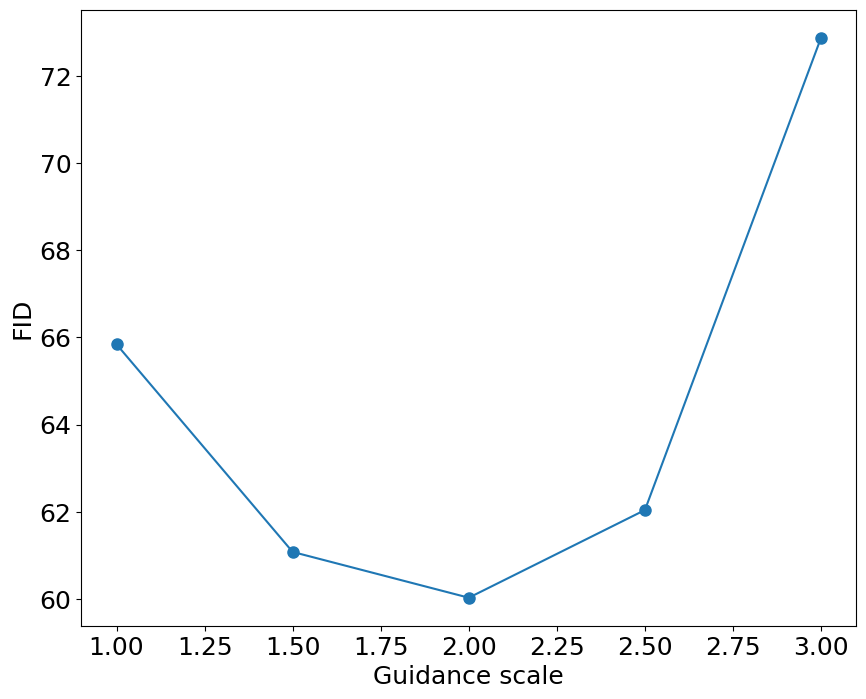

In [59]:
plt.figure(figsize=(10, 8))
plt.plot(cf_scales, fids, marker='o', markersize=8)
plt.xlabel("Guidance scale")
plt.ylabel("FID")
plt.savefig("../final_report/fid_gs.pdf")
plt.show()

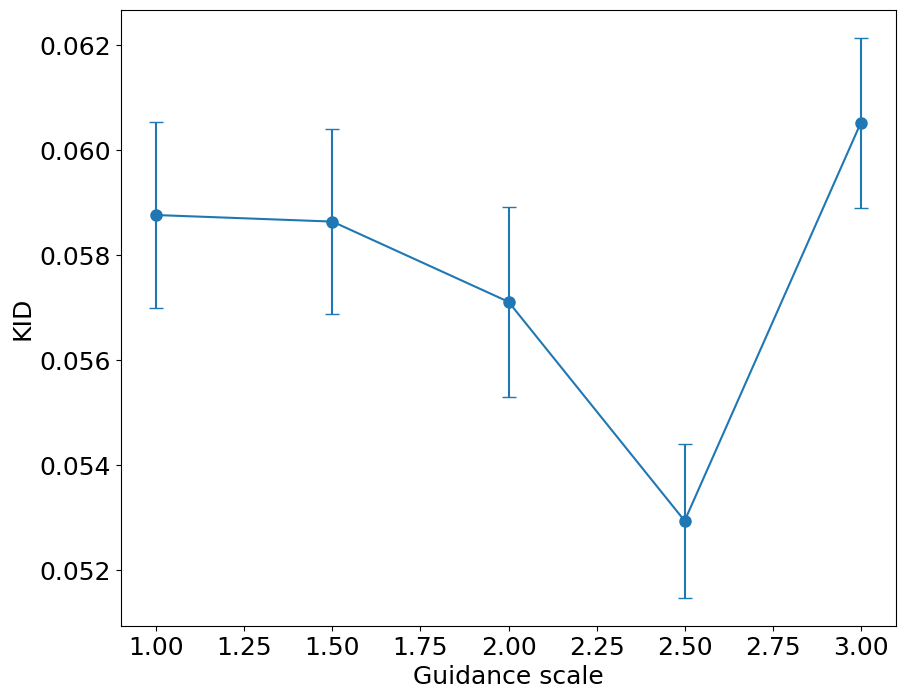

In [60]:
plt.figure(figsize=(10, 8))
# plt.plot(cf_scales, kids, marker='o', markersize=8)
plt.errorbar(cf_scales, kids, yerr=kid_errors, capsize=5, marker='o', markersize=8)
plt.xlabel("Guidance scale")
plt.ylabel("KID")
plt.savefig("../final_report/kid_gs.pdf")
plt.show()

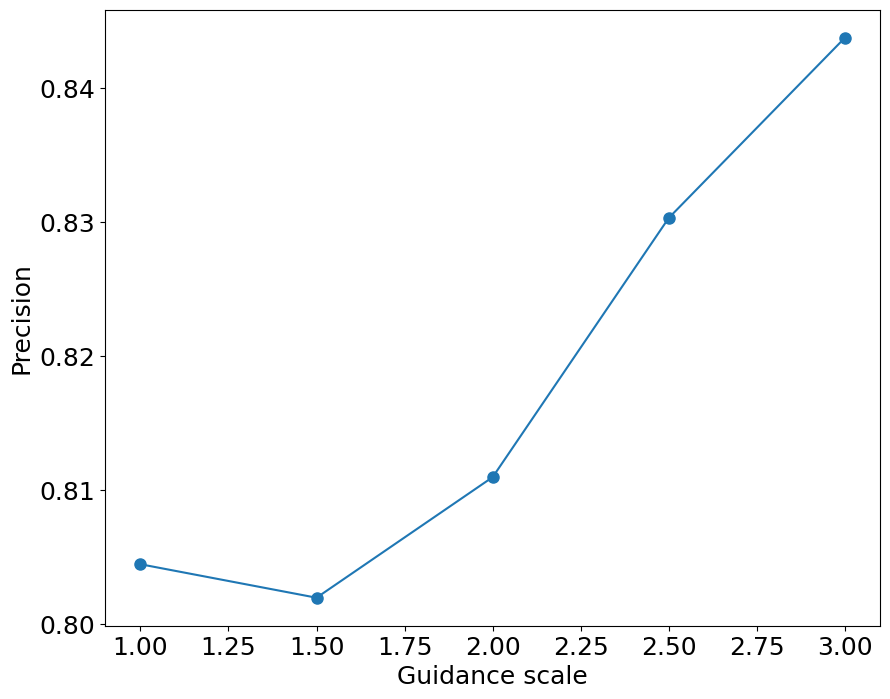

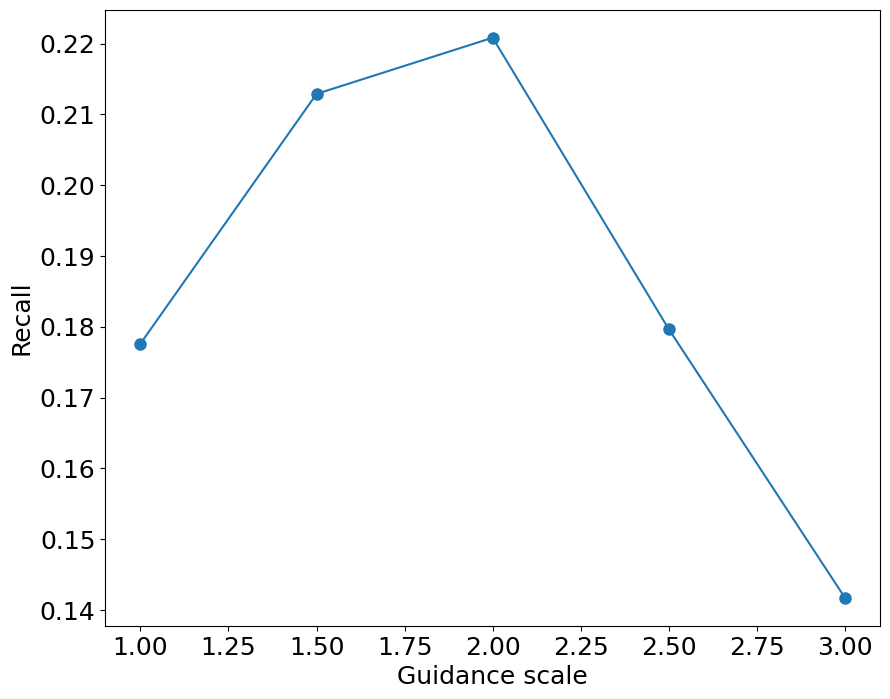

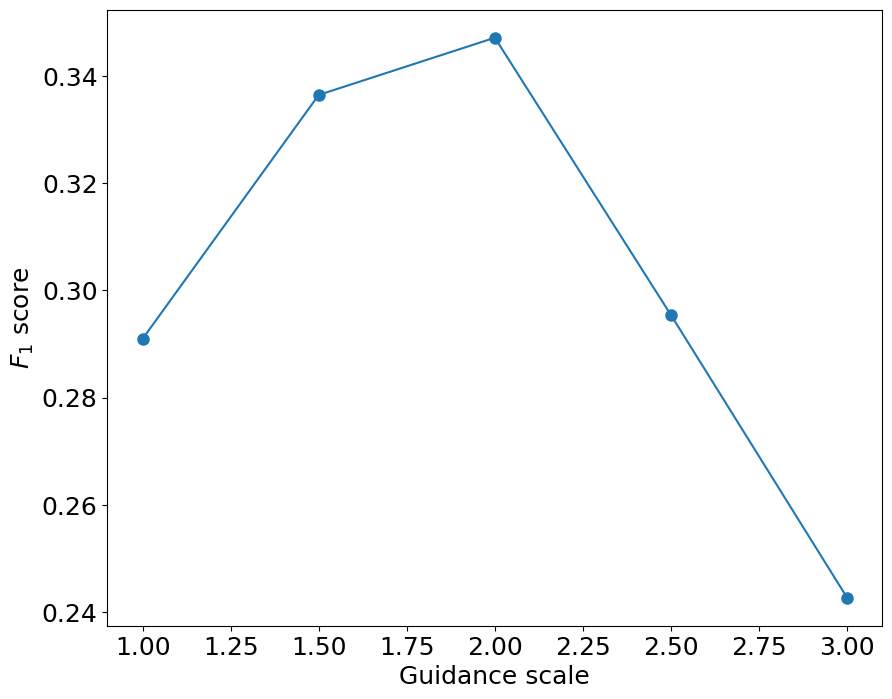

In [64]:
plt.figure(figsize=(10, 8))
plt.plot(cf_scales, precisions, marker='o', markersize=8)
# plt.plot(cf_scales, recalls, marker='o', markersize=8)
# plt.plot(cf_scales, f1s, marker='o', markersize=8)

# plt.errorbar(cf_scales, kids, yerr=kid_errors, capsize=5, marker='o', markersize=8)
plt.xlabel("Guidance scale")
plt.ylabel("Precision")
plt.savefig("../final_report/precision_gs.pdf")
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(cf_scales, recalls, marker='o', markersize=8)
# plt.plot(cf_scales, recalls, marker='o', markersize=8)
# plt.plot(cf_scales, f1s, marker='o', markersize=8)

# plt.errorbar(cf_scales, kids, yerr=kid_errors, capsize=5, marker='o', markersize=8)
plt.xlabel("Guidance scale")
plt.ylabel("Recall")
plt.savefig("../final_report/recall_gs.pdf")
plt.show()

plt.figure(figsize=(10, 8))
# plt.plot(cf_scales, recalls, marker='o', markersize=8)
# plt.plot(cf_scales, recalls, marker='o', markersize=8)
plt.plot(cf_scales, f1s, marker='o', markersize=8)

# plt.errorbar(cf_scales, kids, yerr=kid_errors, capsize=5, marker='o', markersize=8)
plt.xlabel("Guidance scale")
plt.ylabel(r"$F_1$ score")
plt.savefig("../final_report/f1_gs.pdf")
plt.show()

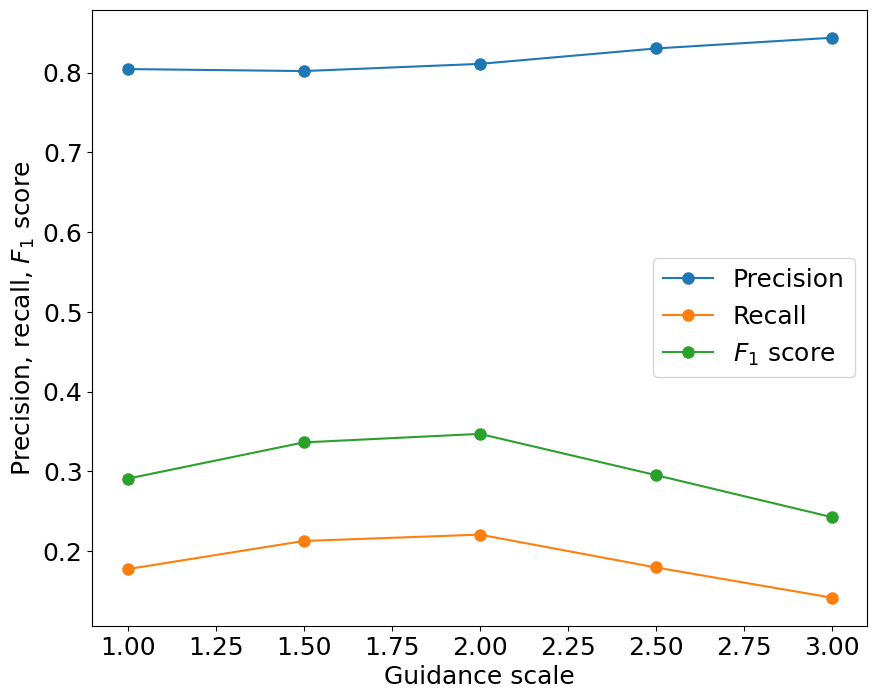

In [65]:
plt.figure(figsize=(10, 8))
plt.plot(cf_scales, precisions, marker='o', markersize=8, label="Precision")
plt.plot(cf_scales, recalls, marker='o', markersize=8, label="Recall")
plt.plot(cf_scales, f1s, marker='o', markersize=8, label=r"$F_1$ score")

# plt.errorbar(cf_scales, kids, yerr=kid_errors, capsize=5, marker='o', markersize=8)
plt.xlabel("Guidance scale")
plt.ylabel(r"Precision, recall, $F_1$ score")
plt.legend()
plt.savefig("../final_report/prc_gs.pdf")
plt.show()

In [24]:
# train_data1, _ = load_data(root_dir="./data3", img_size=IMG_SIZE)

# train_data1.image_only(True)
# data_transforms = [
#     # transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomHorizontalFlip(),
#     transforms.PILToTensor()
#     # transforms.ToTensor(), # Scales data into [0,1]
#     # transforms.RandomRotation(degrees=180, fill=128),
#     # transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
# ]
# data_transform = transforms.Compose(data_transforms)

# train_data1.transform = data_transform

Dataset size: 20000
Dataset size: 2000


In [33]:
import torch_fidelity
metrics_dict = torch_fidelity.calculate_metrics(
    input1="evaluations/v3/cf1.5/images", 
    input2="evaluations/v3/cf2/normal_cosine/images", 
    cuda=True, 
    # isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=True,
)

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf1.5/images" with extensions png,jpg,jpeg
Found 3000 samples
Processing samples                                                           
Extracting features from input2
Looking for samples non-recursivelty in "evaluations/v3/cf2/normal_cosine/images" with extensions png,jpg,jpeg
Found 3000 samples
Processing samples                                                           
Frechet Inception Distance: 6.613745607710172
Kernel Inception Distance: 0.0005539072447447646 ± 0.0002235912029856476         
Creating feature extractor "vgg16" with features ['fc2_relu']
Extracting features from input1
Looking for samples non-recursivelty in "evaluations/v3/cf1.5/images" with extensions png,jpg,jpeg
Found 3000 samples
Processing samples                                                           
Extracting features from input2
Looking fo

In [ ]:
all_captions = pd.unique(train_data.captions)



# CLIP interpolation

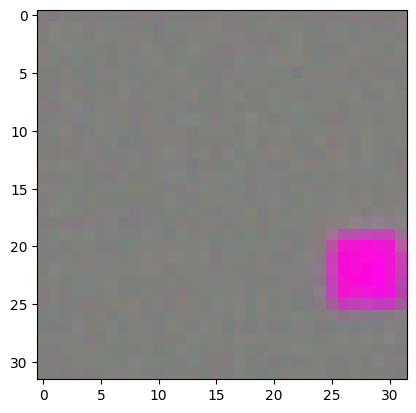

In [27]:
image1 = dalle2((3, IMG_SIZE, IMG_SIZE), "a small magenta square", cf_guidance_scale=2)
show_tensor_image(image1.detach().cpu())

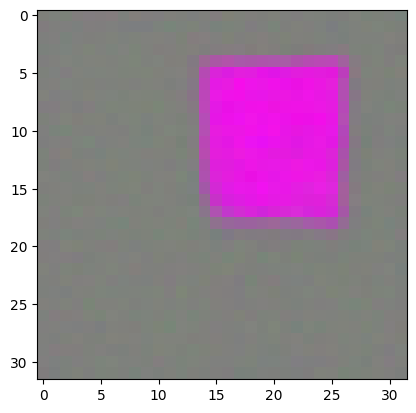

In [26]:
image2 = dalle2((3, IMG_SIZE, IMG_SIZE), "a large magenta square", cf_guidance_scale=2)
show_tensor_image(image2.detach().cpu())

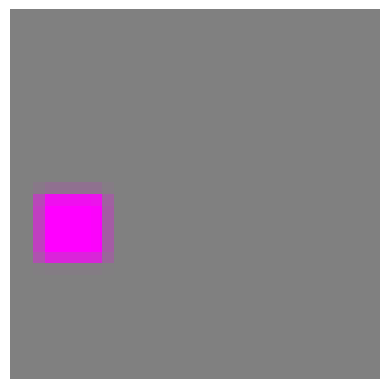

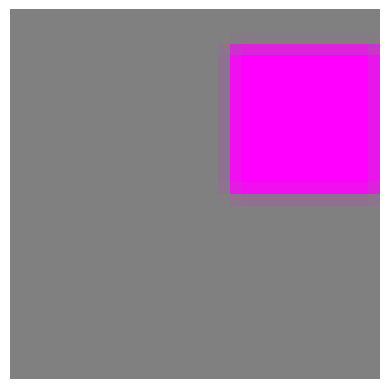

In [48]:
image1 = (train_data[507][0])

image2 = (train_data[754][0])

show_tensor_image(image1)
show_tensor_image(image2)


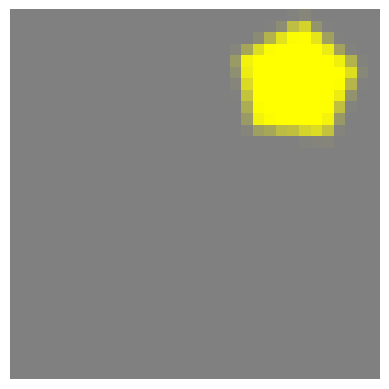

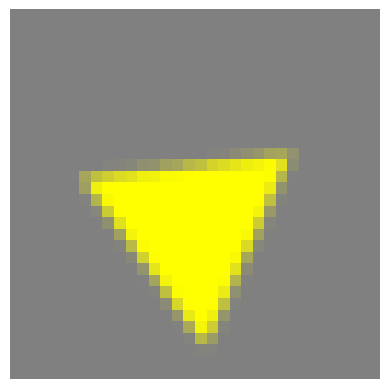

In [84]:
image1 = (train_data[66][0])

image2 = (train_data[2573][0])

show_tensor_image(image1)
show_tensor_image(image2)

In [85]:
im1 = clip.encode_image(image1[None, :].to(device=device), normalize=True).detach()
im2 = clip.encode_image(image2[None, :].to(device=device), normalize=True).detach()

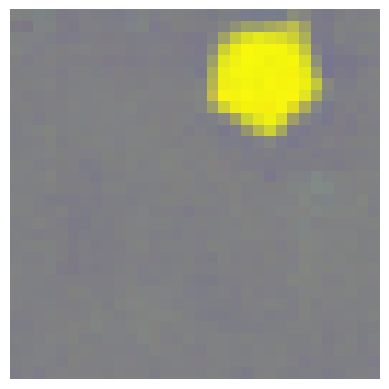

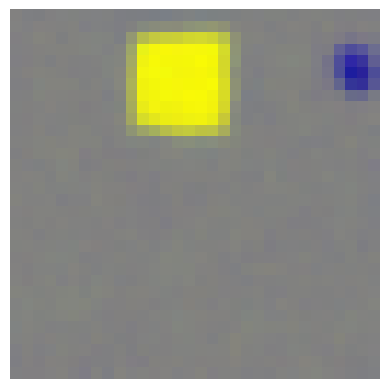

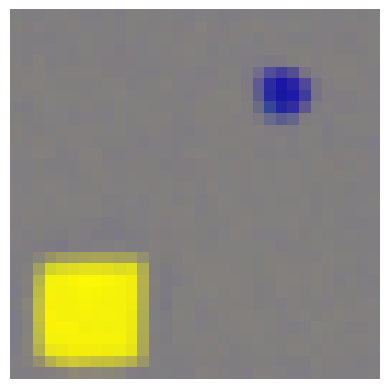

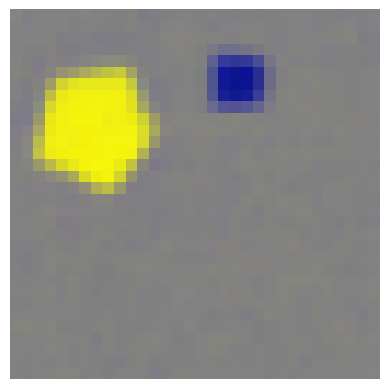

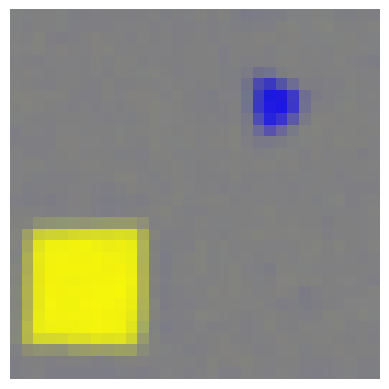

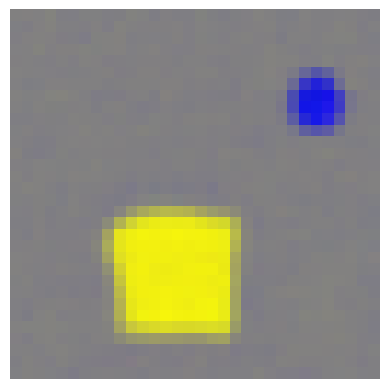

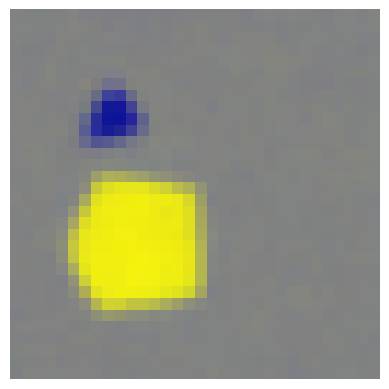

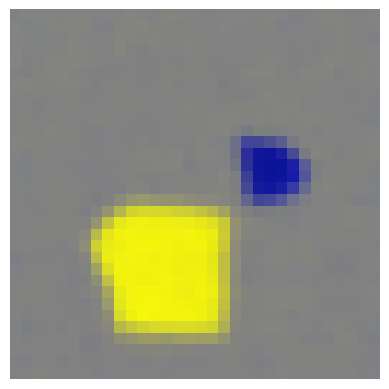

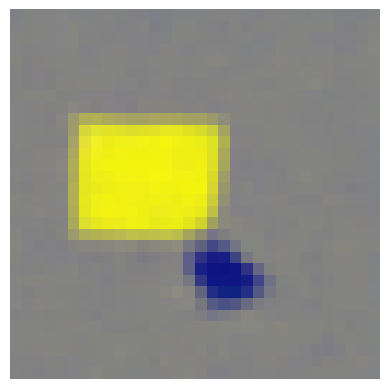

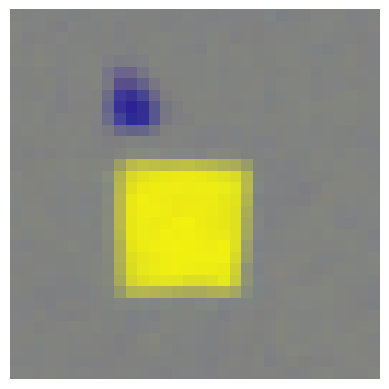

In [86]:
ratio = np.linspace(0, 1, 10)
NULL_TEXT_TOKEN = torch.zeros((1, CONTEXT_LENGTH), dtype=torch.int, device=device)

torch.manual_seed(1)
for r in ratio:
    im = (im2 * r + im1 * (1 - r))
    image = dalle2.decoder.sample_one((3, IMG_SIZE, IMG_SIZE),
                                    NULL_TEXT_TOKEN,
                                    clip_emb=im,
                                    cf_guidance_scale=2)
    show_tensor_image(image.detach().cpu())

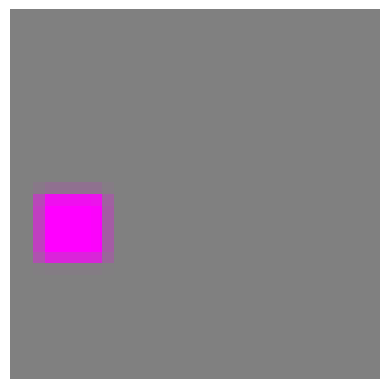

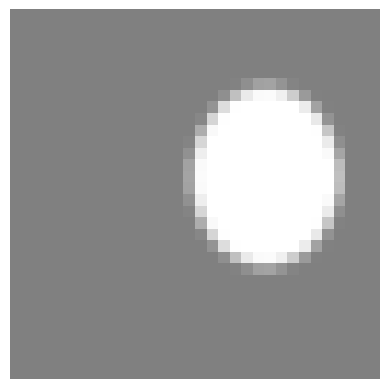

In [91]:
image1 = (train_data[507][0])

image2 = (train_data[1116][0])

show_tensor_image(image1)
show_tensor_image(image2)

In [92]:
im1 = clip.encode_image(image1[None, :].to(device=device), normalize=True).detach()
im2 = clip.encode_image(image2[None, :].to(device=device), normalize=True).detach()

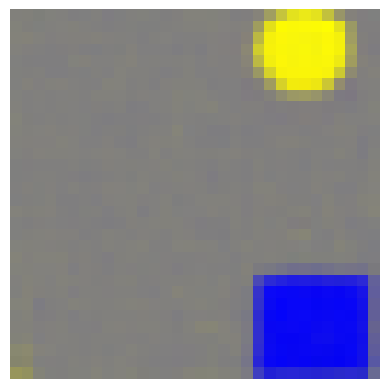

In [73]:
image1 = dalle2((3, IMG_SIZE, IMG_SIZE), "a large magenta square and a white rectangle", cf_guidance_scale=0)
show_tensor_image(image1.detach().cpu())

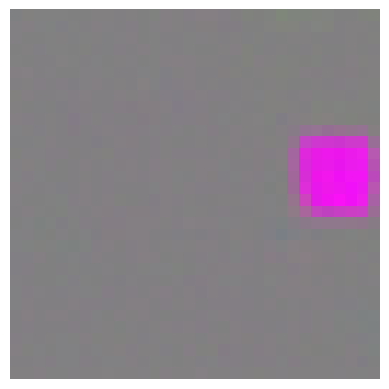

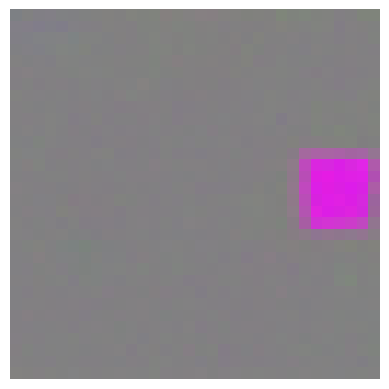

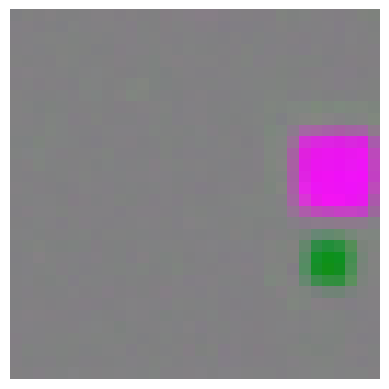

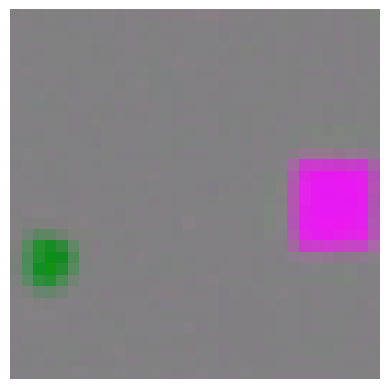

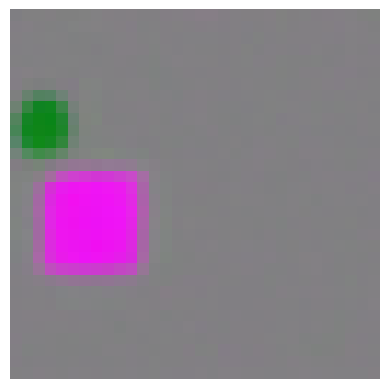

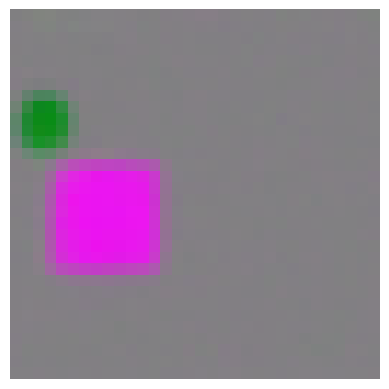

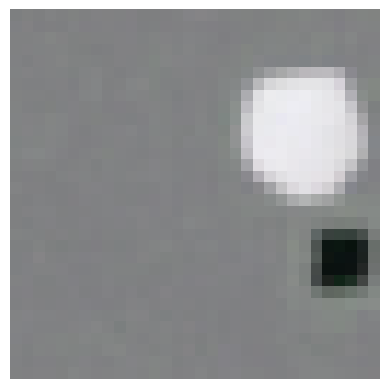

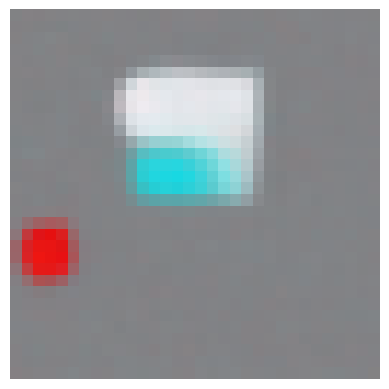

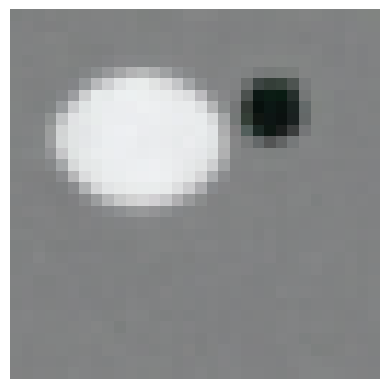

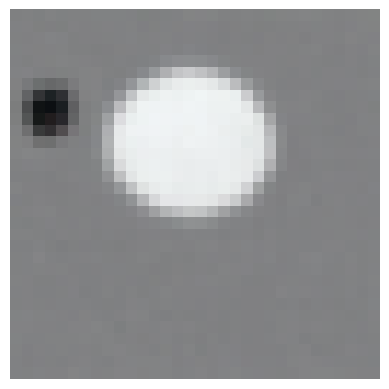

In [95]:
ratio = np.linspace(0, 1, 10)
NULL_TEXT_TOKEN = torch.zeros((1, CONTEXT_LENGTH), dtype=torch.int, device=device)

for r in ratio:
    im = (im2 * r + im1 * (1 - r))
    torch.manual_seed(10)
    image = dalle2.decoder.sample_one((3, IMG_SIZE, IMG_SIZE),
                                    NULL_TEXT_TOKEN,
                                    clip_emb=im,
                                    cf_guidance_scale=2)
    show_tensor_image(image.detach().cpu())

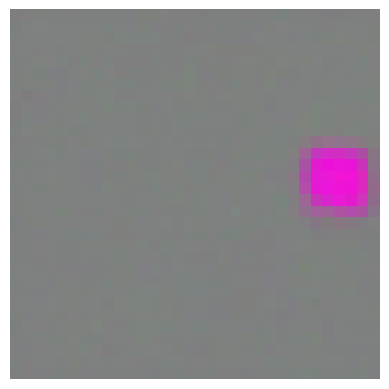

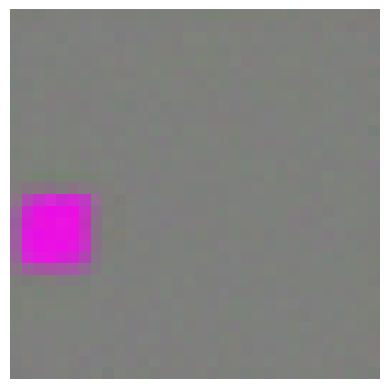

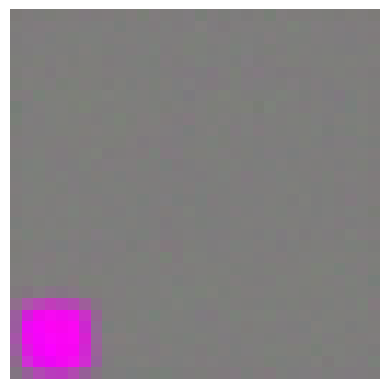

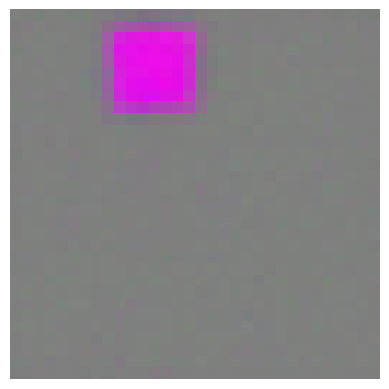

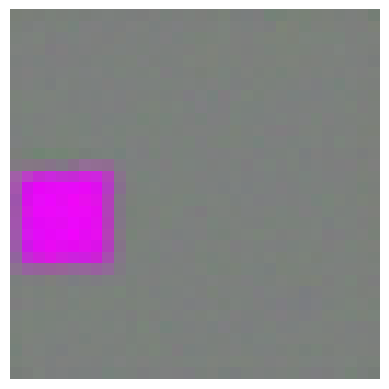

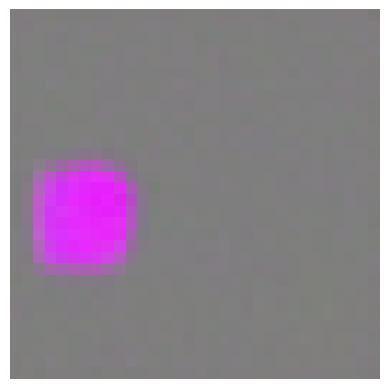

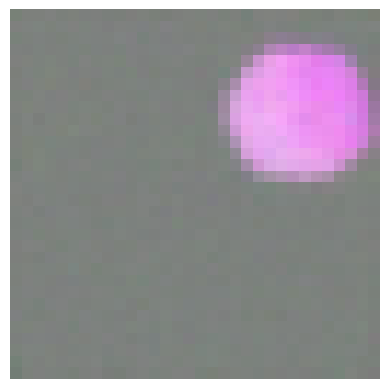

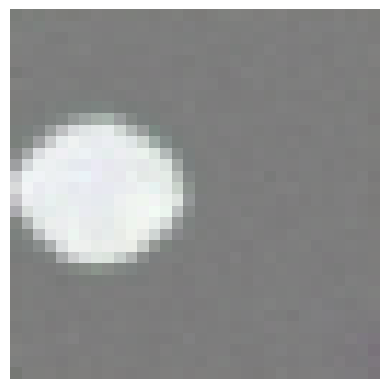

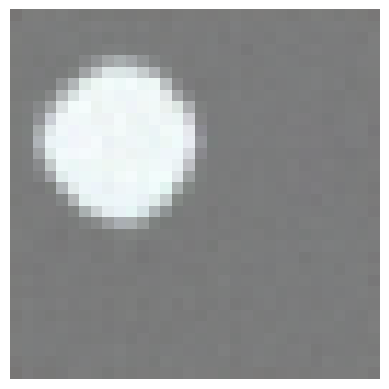

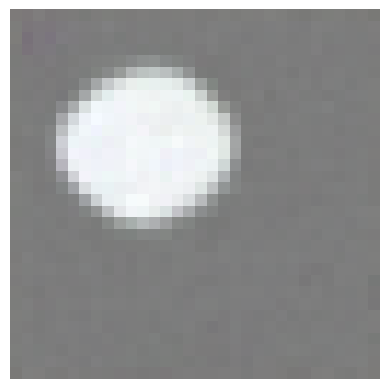

In [ ]:
ratio = np.linspace(0, 1, 10)
NULL_TEXT_TOKEN = torch.zeros((1, CONTEXT_LENGTH), dtype=torch.int, device=device)

torch.manual_seed(1)
for r in ratio:
    im = (im2 * r + im1 * (1 - r))
    image = dalle2.decoder.sample_one((3, IMG_SIZE, IMG_SIZE),
                                    NULL_TEXT_TOKEN,
                                    clip_emb=im,
                                    cf_guidance_scale=2.5)
    show_tensor_image(image.detach().cpu())

## Text diff

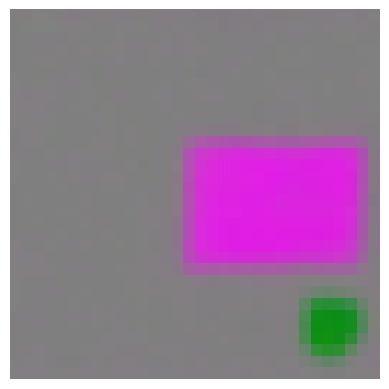

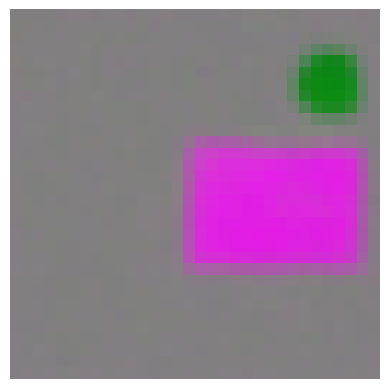

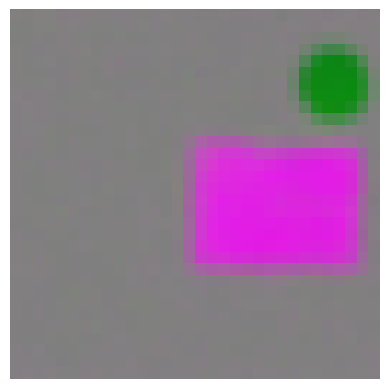

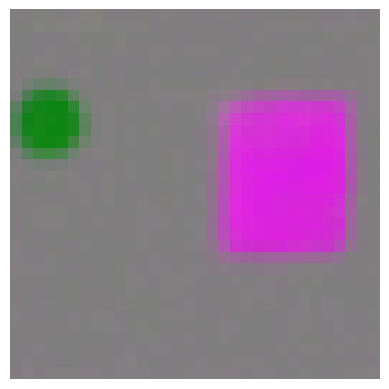

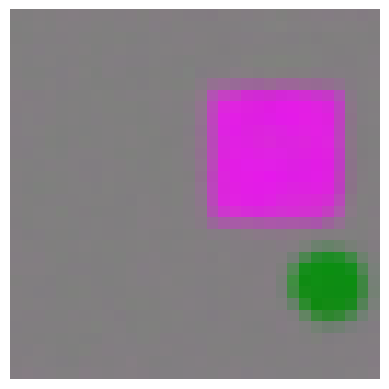

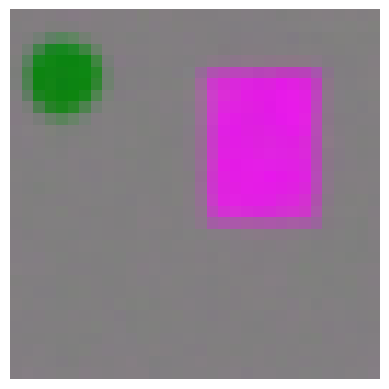

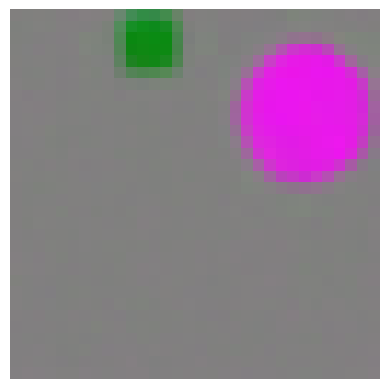

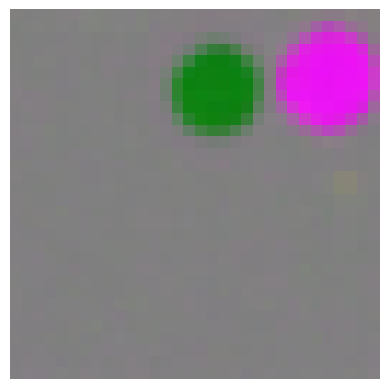

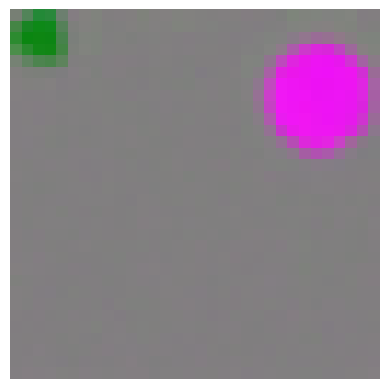

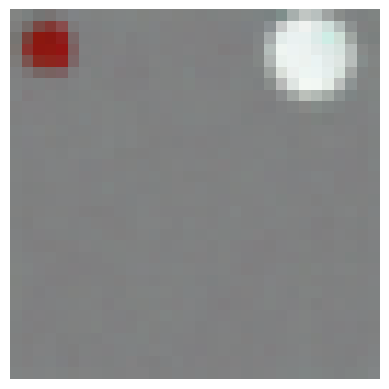

In [25]:
ratio = np.linspace(0, 1, 10)
NULL_TEXT_TOKEN = torch.zeros((1, CONTEXT_LENGTH), dtype=torch.int, device=device)
caption0 = "a large magenta rectangle"
caption1 = "a large magenta circle"
t0 = tokenize(caption0, context_length=CONTEXT_LENGTH).to(device=device)
t1 = tokenize(caption1, context_length=CONTEXT_LENGTH).to(device=device)

zt0, encodings = dalle2.clip.encode_text(t0, normalize=True, return_encodings=True)
zt1 = dalle2.clip.encode_text(t1, normalize=True)

diff = zt1 - zt0
diff = diff / diff.norm(dim=-1)

zi = dalle2.prior.sample(text_emb=zt0, text_encodings=encodings)
for r in ratio:
    torch.manual_seed(1)
    im = zi + r * (diff - zi)
    image = dalle2.decoder.sample_one((3, IMG_SIZE, IMG_SIZE),
                                    NULL_TEXT_TOKEN,
                                    clip_emb=im,
                                    cf_guidance_scale=2)
    show_tensor_image(image.detach().cpu())